# Исследование различных подходов машинного обучения на больших данных с использованием PySpark

### Сравнение эффективности единой распределенной модели и нескольких параллельных моделей на примере задачи предсказания количества заказов такси на следующий час в Чикаго

Данные для задачи были взяты с официального портала данных города Чикаго https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew по поездкам такси за 2022 и неполный 2023 год.

**Цель работы.** Сравнить различные подходы машинного обучения на больших данных с использованием PySpark  

**План работы**  
1. Загрузить и изучить данные. Провести исследовательский анализ
2. Провести обработку и агрегацию данных
3. Провести Feature Engineering
4. Обучить несколько моделей и сравнить результаты обучения  
   - Распределенные модели PySpark 
   - Параллельное обучение с группировкой и использованием PandasUDF
5. Сделть сравнение и сформулировать выводы и рекомендации для применения и возможных улучшений.

In [1]:
!pip install mlflow 
!pip install shap
!pip install geopandas
!pip install hyperopt
!pip install xgboost

  Obtaining dependency information for mlflow from https://files.pythonhosted.org/packages/5d/c8/2ddb5e1d0f75a088b8580868ca439221d3a1d9649a52eb7f940ecc5b5c9f/mlflow-2.6.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 493.2 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.5 MB/s eta 0:00:00
  Obtaining dependency information for docker<7,>=4.0.0 from https://files.pythonhosted.org/packages/db/be/3032490fa33b36ddc8c4b1da3252c6f974e7133f1a50de00c6b85cca203a/docker-6.1.3-py3-none-any.whl.metadata
  Obtaining dependency information for Flask<3 from https://files.pythonhosted.org/packages/fd/56/26f0be8adc2b4257df20c1c4260ddd0aa396cf8e75d90ab2f7ff99bc34f9/flask-2.3.3-py3-none-any.whl.metadata
  Obtaining dependency information for markdown<4,>=3.3 from https://files.pythonhosted.org/packages/1a/b5/228c1cdcfe138f1a8e01ab1b54284c8b83735476cb22b6ba251656ed13ad/Markdown-3.4.4-py3-n

In [2]:
import geopandas as gpd
import hyperopt
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import pyspark
import seaborn as sns
import shap
import xgboost

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from IPython import display
from pyspark import SparkConf, SparkContext
from pyspark.sql import DataFrame, SparkSession, SQLContext
from pyspark.sql import functions as F
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, FloatType, IntegerType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from shapely import wkt
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from xgboost.spark import SparkXGBRegressor

from spark_mlflow_config import MLFLOW_TRACKING_URI, SPARK_MASTER_IP

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
# Установка параметров
mlflow.set_tracking_uri(f'http://{MLFLOW_TRACKING_URI}:5000')
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

In [4]:
# Инициализация Spark сессии
spark = SparkSession.builder.appName("pyspark-taxi-forecasting") \
    .master(f"spark://{SPARK_MASTER_IP}:7077") \
    .config("spark.executor.cores", 1) \
    .config("spark.task.cpus", 1) \
    .config("spark.ui.reverseProxyPort", "8080") \
    .config('spark.ui.port', '4040') \
    .getOrCreate()

In [5]:
spark

#### Считывание данных

In [6]:
csv_path_2022 = 'data/Taxi_Trips_-_2022.csv'

In [7]:
csv_path_2023 = 'data/Taxi_Trips_-_2023.csv'

In [8]:
data_2022 = spark.read.csv(csv_path_2022, header=True, inferSchema=True)

In [9]:
data_2023 = spark.read.csv(csv_path_2023, header=True, inferSchema=True)

In [10]:
df_union = data_2022.union(data_2023)

### EDA

In [11]:
# Считываем данные о географических координатах регионов
geo_df = pd.read_csv('weather_data/comm_areas_geo.csv')
# Переводим номера регионов в строчный тип для корректного соединения таблиц
geo_df['AREA_NUM_1'] = geo_df['AREA_NUM_1'].astype('str')
# Создаем GeoDataFrame
geo_df['the_geom'] = geo_df['the_geom'].apply(wkt.loads)

In [12]:
def plot_on_map(geo_df, df_plot, value, vmin=None, vmax=None):
    """
    Функция для построения распределения различных величин по районам.
    """
    offset = 0.007
    
    # Присоединяем датафрейм с метриками к геодатафрейму
    df_plot['region'] = df_plot['region'].astype('int').astype('str')
    geo_df = geo_df.merge(df_plot, left_on='AREA_NUM_1', right_on='region', how='left')
    gdf = gpd.GeoDataFrame(geo_df, geometry='the_geom')
    
    # Задаем размер графика
    fig, ax = plt.subplots(figsize=(11, 11))
    
    # Рисуем многоугольники с раскрашиванием по 'MAE' и добавляем легенду
    gdf.plot(ax=ax,
             column=value, 
             legend=True, 
             cmap='crest',
             vmin=vmin,
             vmax=vmax)

    # Добавляем метки регионов и значения метрики на центроиды многоугольников
    for x, y, label, metric_value in zip(gdf['the_geom'].centroid.x, gdf['the_geom'].centroid.y, gdf['region'], gdf[value]):
        ax.text(x, y, label, fontsize=8, ha='center')  # Метки регионов
        ax.text(x, y - offset, str(round(metric_value, 2)), fontsize=8, ha='center', color='white')  # Метрики
    plt.show()

In [13]:
df_union.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid 

In [14]:
df_union.dtypes

[('Trip ID', 'string'),
 ('Taxi ID', 'string'),
 ('Trip Start Timestamp', 'string'),
 ('Trip End Timestamp', 'string'),
 ('Trip Seconds', 'int'),
 ('Trip Miles', 'double'),
 ('Pickup Census Tract', 'bigint'),
 ('Dropoff Census Tract', 'bigint'),
 ('Pickup Community Area', 'int'),
 ('Dropoff Community Area', 'int'),
 ('Fare', 'double'),
 ('Tips', 'double'),
 ('Tolls', 'double'),
 ('Extras', 'double'),
 ('Trip Total', 'double'),
 ('Payment Type', 'string'),
 ('Company', 'string'),
 ('Pickup Centroid Latitude', 'double'),
 ('Pickup Centroid Longitude', 'double'),
 ('Pickup Centroid Location', 'string'),
 ('Dropoff Centroid Latitude', 'double'),
 ('Dropoff Centroid Longitude', 'double'),
 ('Dropoff Centroid  Location', 'string')]

In [15]:
df_union.count()

10166155

Более 10 млн. строк

In [16]:
df_union.describe().toPandas().transpose()

0                      1  \
summary                        count                   mean   
Trip ID                     10166155                   None   
Taxi ID                     10166155                   None   
Trip Start Timestamp        10166155                   None   
Trip End Timestamp          10165895                   None   
Trip Seconds                10163972     1212.0242641361074   
Trip Miles                  10166086      6.291890338130646   
Pickup Census Tract          4274063  1.7031481089731644E10   
Dropoff Census Tract         4292954  1.7031412889425909E10   
Pickup Community Area        9484535      33.37239348054491   
Dropoff Community Area       9167787      25.93815214075109   
Fare                        10157216     21.828337769917052   
Tips                        10157216     2.8184714935667383   
Tolls                       10157216    0.03196697894383657   
Extras                      10157216      2.192354772213174   
Trip Total                  10157216     27.028215008915478   
Payment Type                10166155                   None   
Company                     10166155                   None   
Pickup Centroid Latitude     9488225      41.90071420959841   
Pickup Centroid Longitude    9488225     -87.69231649408452   
Pickup Centroid Location     9488225                   None   
Dropoff Centroid Latitude    9226429      41.89451909518304   
Dropoff Centroid Longitude   9226429     -87.66244074009379   
Dropoff Centroid  Location   9226429                   None   

                                               2  \
summary                                   stddev   
Trip ID                                     None   
Taxi ID                                     None   
Trip Start Timestamp                        None   
Trip End Timestamp                          None   
Trip Seconds                  1838.1457431620122   
Trip Miles                     7.854138068892412   
Pickup Census Tract           371070.35268495115   
Dropoff Census Tract           345149.1818247522   
Pickup Community Area         25.573593422863787   
Dropoff Community Area        20.922977233279006   
Fare                           41.44270782407734   
Tips                          4.1284548327416735   
Tolls                           9.30823962953345   
Extras                         20.93582367189818   
Trip Total                     50.47904830699149   
Payment Type                                None   
Company                                     None   
Pickup Centroid Latitude    0.061070201787963935   
Pickup Centroid Longitude    0.10772364430842647   
Pickup Centroid Location                    None   
Dropoff Centroid Latitude    0.05634197724844833   
Dropoff Centroid Longitude   0.07337047565153403   
Dropoff Centroid  Location                  None   

                                                                            3  \
summary                                                                   min   
Trip ID                              000000bb18f0563c13ad977fc05b901474cd3941   
Taxi ID                     00110971c7c4a7173fcf93f49a22d6b9b0a02c27c4b9f8...   
Trip Start Timestamp                                   01/01/2022 01:00:00 AM   
Trip End Timestamp                                     01/01/2022 01:00:00 AM   
Trip Seconds                                                                0   
Trip Miles                                                                0.0   
Pickup Census Tract                                               17031010100   
Dropoff Census Tract                                              17031010100   
Pickup Community Area                                                       1   
Dropoff Community Area                                                      1   
Fare                                                                      0.0   
Tips                                                                      0.0   
Tolls                   

#### Количество пропущенных значений по колонкам

In [18]:
df_union.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df_union.columns]).toPandas().transpose()

0
Trip ID                           0
Taxi ID                           0
Trip Start Timestamp              0
Trip End Timestamp              260
Trip Seconds                   2183
Trip Miles                       69
Pickup Census Tract         5892092
Dropoff Census Tract        5873201
Pickup Community Area        681620
Dropoff Community Area       998368
Fare                           8939
Tips                           8939
Tolls                          8939
Extras                         8939
Trip Total                     8939
Payment Type                      0
Company                           0
Pickup Centroid Latitude     677930
Pickup Centroid Longitude    677930
Pickup Centroid Location     677930
Dropoff Centroid Latitude    939726
Dropoff Centroid Longitude   939726
Dropoff Centroid  Location   939726

Наиболее важные колокни 'Trip Start Timestamp' пропусков не имеет.  
Пропуски в 'Pickup Community Area' означают поездки из загородных локаций, их мы учитывать не будем.  
Пропуски в 'Trip End Timestamp' - всего 260 шт. Возможно на момент формирования данных эти поездки еще не были завершены.  
Пропусков в 'Trip Second' больше. При необъодимости можно восстановить пропущенные данные через данные о начале и конце поездки.  
Также есть около 9тыс пропущенных значений информации об оплате.  
Пропуски в других геоданных для нас возможно не критичны.

In [19]:
# Создадим временное представление таблицы
df_union.createOrReplaceTempView("table_data")

#### Среднее количество поездок в день по районам

In [20]:
query = """
    SELECT AVG(rides) as avg_rides,
           region
    FROM (
    SELECT COUNT(`Trip ID`) as rides,
           `Pickup Community Area` as region,
           DATE_TRUNC('DAY', TO_TIMESTAMP(`Trip Start Timestamp`, 'MM/dd/yyyy hh:mm:ss a')) as day
    FROM table_data
    GROUP BY region, day)
    GROUP BY region
    ORDER BY region
    """
res = spark.sql(query)

In [21]:
rides_per_day = res.toPandas().dropna()
rides_per_day['region'] = rides_per_day['region'].astype('int')

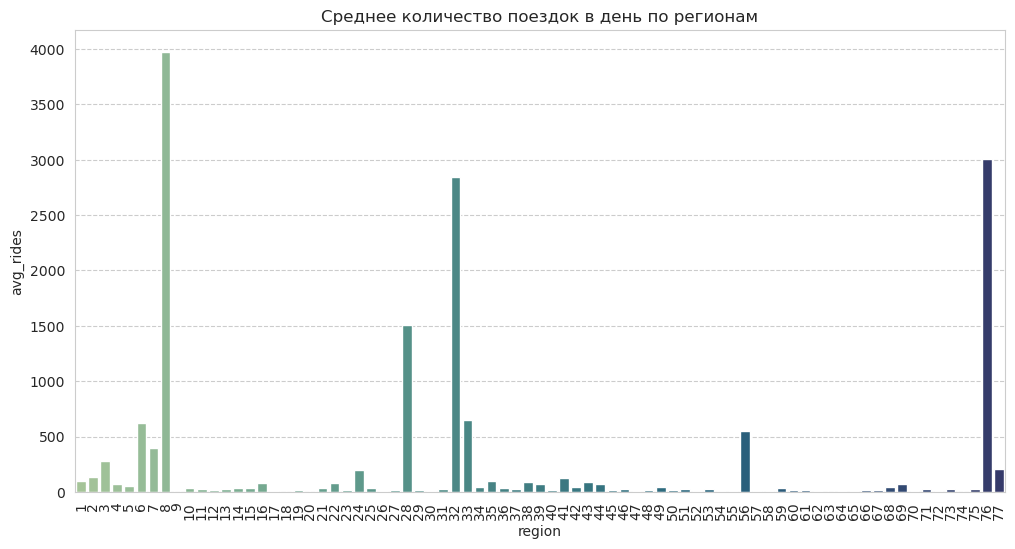

In [22]:
# Строим график
plt.subplots(figsize=(12, 6))
sns.barplot(data=rides_per_day, x='region', y='avg_rides', palette='crest')
plt.tick_params(axis="x", labelrotation=90)
plt.title('Среднее количество поездок в день по регионам');

In [23]:
# Логарифмируем для сравнения
rides_per_day['log_avg_rides'] = rides_per_day['avg_rides'].apply(np.log)

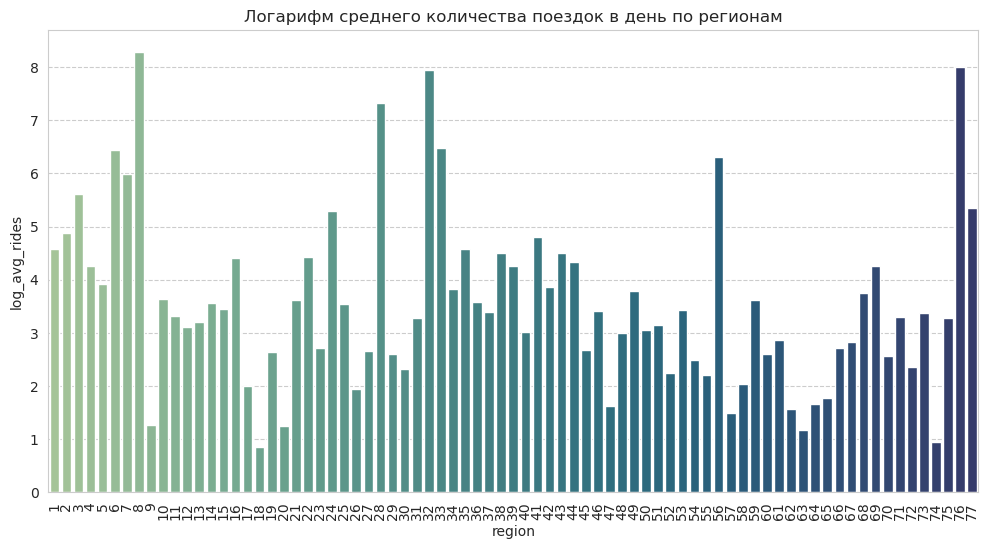

In [24]:
# Строим график
plt.subplots(figsize=(12, 6))
sns.barplot(data=rides_per_day, x='region', y='log_avg_rides', palette='crest')
plt.tick_params(axis="x", labelrotation=90)
plt.title('Логарифм среднего количества поездок в день по регионам');

По среднему количеству поездок в день регионы могут различаться на несколько порядков. Следует также принимать во внимание площадь районов, т.к. некоторые районы большие, некоторые маленькие.

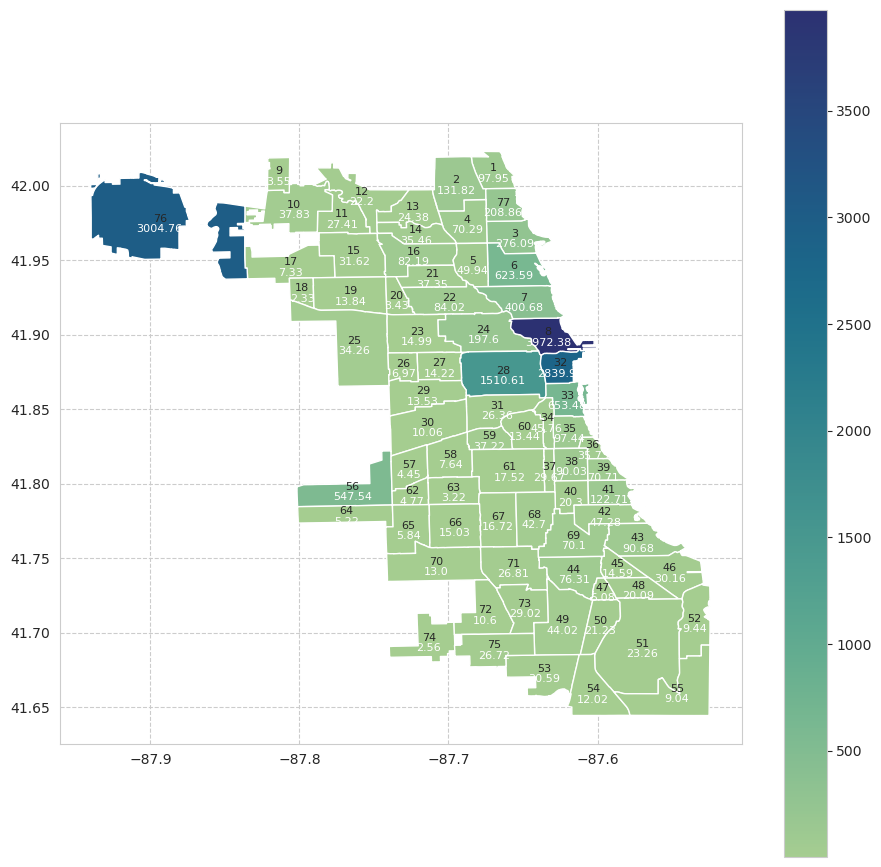

In [25]:
plot_on_map(geo_df, rides_per_day, 'avg_rides')

Наиболее востребованные районы для поездок такси - аэропорты и центральные районы.

#### Час суток

In [26]:
query = """
    SELECT AVG(trips_num) as trips,
           EXTRACT('HOUR', hour) as ext_hour
    FROM
    (SELECT COUNT(`Trip ID`) as trips_num,
           DATE_TRUNC('HOUR', TO_TIMESTAMP(`Trip Start Timestamp`, 'MM/dd/yyyy hh:mm:ss a')) as hour
    FROM table_data
    GROUP BY hour)
    GROUP BY ext_hour
    ORDER BY ext_hour
"""
res = spark.sql(query)

In [27]:
orders_per_hour = res.toPandas()

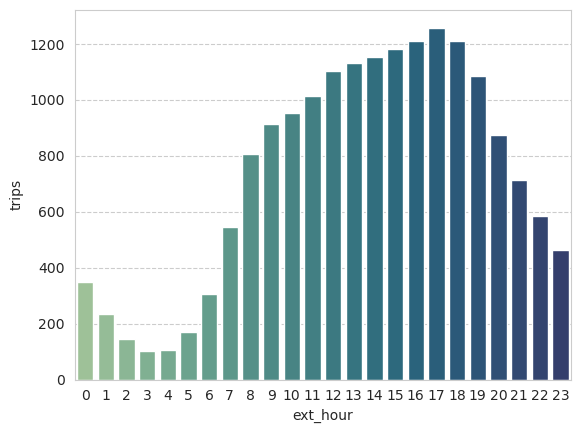

In [28]:
sns.barplot(data=orders_per_hour, x='ext_hour', y='trips', palette='crest');

Ожидаемо видим снижение активности поездок в ночные часы, резкий рост с 6 до 9. Более плавный рост с 9 до 17 и быстрое снижение с 18 до 23 часов. В качестве признаков для предсказания количества заказов очевидно следует учитывать час суток.

#### Нормализованное среднее число поездок по регионам

In [29]:
query = """
    SELECT AVG(trips_num) as trips,
           EXTRACT('HOUR', hour) as ext_hour,
           `Pickup Community Area` as region
    FROM
    (SELECT COUNT(`Trip ID`) as trips_num,
           DATE_TRUNC('HOUR', TO_TIMESTAMP(`Trip Start Timestamp`, 'MM/dd/yyyy hh:mm:ss a')) as hour,
           `Pickup Community Area`
    FROM table_data
    GROUP BY hour, `Pickup Community Area`)
    GROUP BY ext_hour, `Pickup Community Area`
    ORDER BY ext_hour
"""

res = spark.sql(query)

In [30]:
hour_by_region = res.toPandas()

In [31]:
def plot_by_region(df: pd.DataFrame, column: str, values: str, title: str):
    # Создадим сводную таблицу
    pivot_t = df.pivot_table(index='region', columns=column, values=values)
    
    # Нормализуем данные по регионам (по строкам)
    norm_pivot = pivot_t.div(pivot_t.sum(axis=1), axis=0)

    plt.figure(figsize=(10, 8))
    sns.heatmap(norm_pivot, cmap="YlGnBu")
    plt.title(title)
    plt.show();

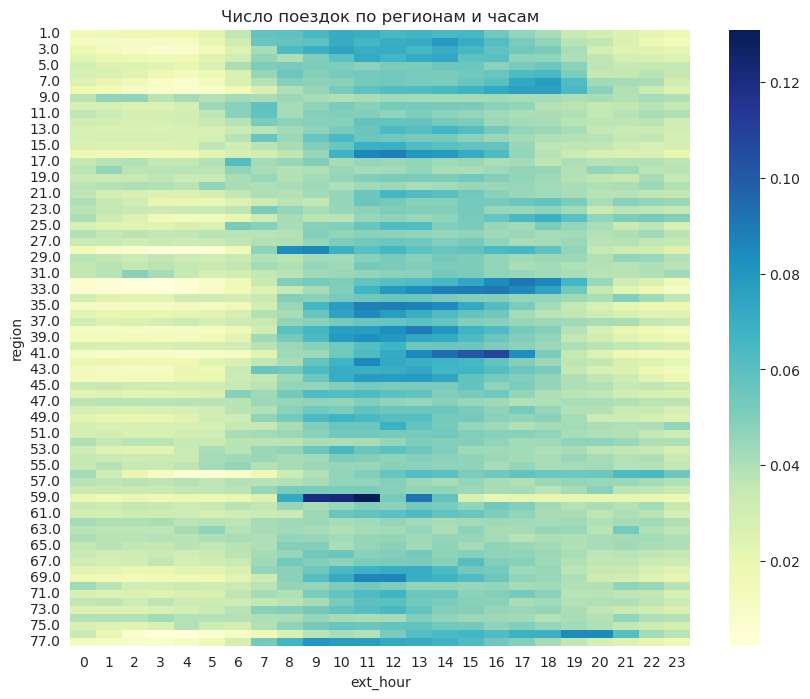

In [32]:
plot_by_region(hour_by_region, 'ext_hour', 'trips', 'Число поездок по регионам и часам')

При построении распределений среднего числа заказов по часам, можем заметить, что для различных районов распределения могут сильно отличаться. Например пики могут быть более или менее выражены, а также смещаться к тому или иному часу.

#### День недели

In [33]:
query = """
    SELECT AVG(trips_num) as trips,
           EXTRACT('DOW', dt) as ext_dow
    FROM
    (SELECT COUNT(`Trip ID`) as trips_num,
           TO_TIMESTAMP(`Trip Start Timestamp`, 'MM/dd/yyyy hh:mm:ss a') as dt
    FROM table_data
    GROUP BY dt)
    GROUP BY ext_dow
    ORDER BY ext_dow
"""
res = spark.sql(query)

In [34]:
orders_per_dow = res.toPandas()

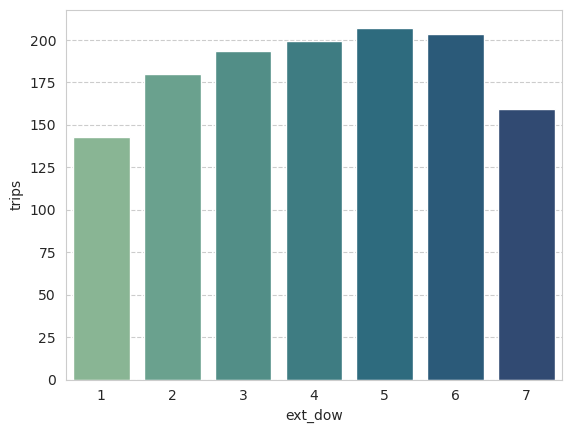

In [35]:
sns.barplot(data=orders_per_dow, x='ext_dow', y='trips', palette='crest');

В среднем в субботу и в воскресенье (6 и 0) поездок меньше чем в остальные дни. С пондельника по четверг среднее число поездок растет. Изменения менее заметны относительно часов, но все же достаточно значимые.

#### Нормализованное среднее число поездок по регионам

In [36]:
query = """
    SELECT AVG(trips_num) as trips,
           EXTRACT('DOW', dt) as ext_dow,
           region
    FROM
    (SELECT COUNT(`Trip ID`) as trips_num,
           TO_TIMESTAMP(`Trip Start Timestamp`, 'MM/dd/yyyy hh:mm:ss a') as dt,
           `Pickup Community Area` as region
    FROM table_data
    GROUP BY dt, region)
    GROUP BY ext_dow, region
    ORDER BY ext_dow
"""
res = spark.sql(query)

In [37]:
dow_by_region = res.toPandas()

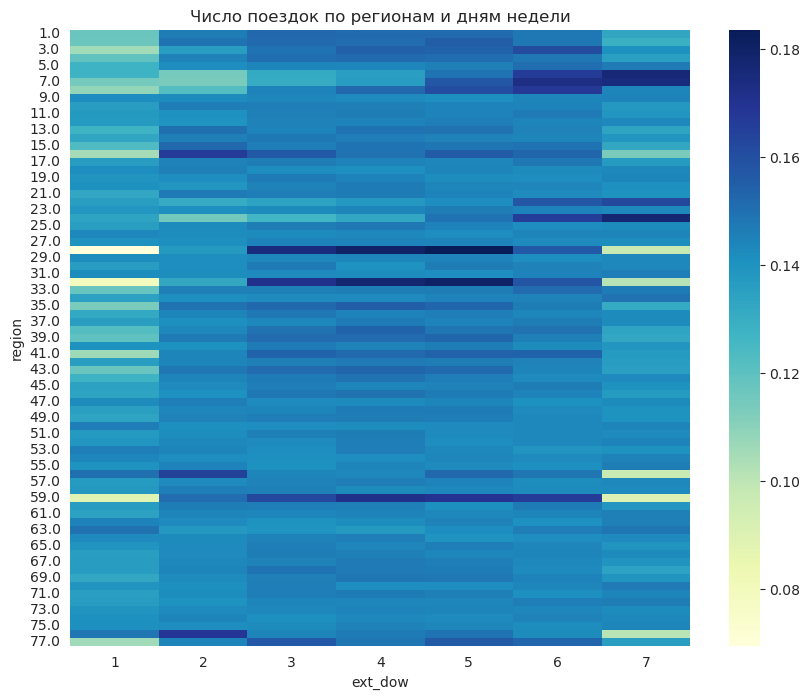

In [38]:
plot_by_region(dow_by_region, 'ext_dow', 'trips', 'Число поездок по регионам и дням недели')

В основном периодичность по районам похожая, но есть районы где разница в количестве поездок по дням различается сильнее.

#### Месяц

In [39]:
query = """
    SELECT AVG(trips_num) as trips,
           DATE_TRUNC('MONTH', dt) as month
    FROM
    (SELECT COUNT(`Trip ID`) as trips_num,
           TO_TIMESTAMP(`Trip Start Timestamp`, 'MM/dd/yyyy hh:mm:ss a') as dt
    FROM table_data
    GROUP BY dt)
    GROUP BY month
    ORDER BY month
"""
res = spark.sql(query)

In [40]:
orders_per_month = res.toPandas()

Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead


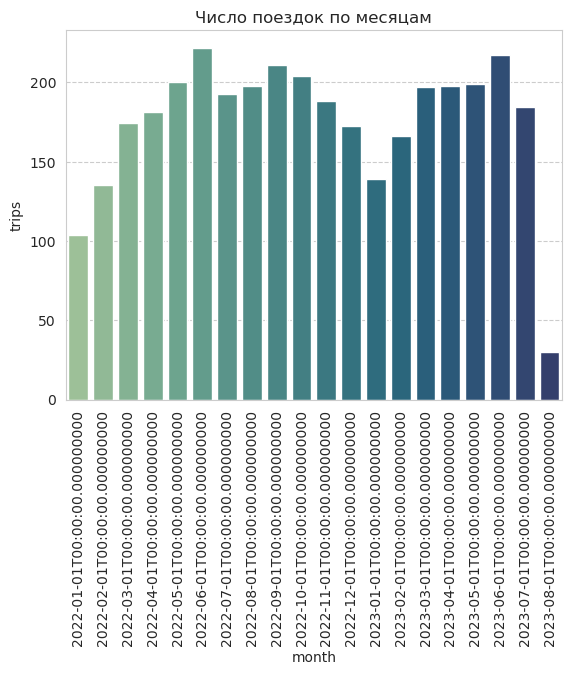

In [41]:
sns.barplot(data=orders_per_month, x='month', y='trips', palette='crest')
plt.tick_params(axis="x", labelrotation=90)
plt.title('Число поездок по месяцам');

Заметна периодичность среднего числа поездок по месяцам. В январе среднее число поездок минимально, в июне - максимально. Также видно, что активность поездок зимой снижается. Последний месяц представлен неполностью, поэтому можно не обращать на него внимания. Минимум в начале периода может быть также связан с коронавирусными ограничениями.

#### Нормализованное среднее число поездок по регионам

In [42]:
query = """
    SELECT AVG(trips_num) as trips,
           DATE_TRUNC('MONTH', dt) as month,
           region
    FROM
    (SELECT COUNT(`Trip ID`) as trips_num,
           TO_TIMESTAMP(`Trip Start Timestamp`, 'MM/dd/yyyy hh:mm:ss a') as dt,
           `Pickup Community Area` as region
    FROM table_data
    GROUP BY dt, region)
    GROUP BY month, region
    ORDER BY month
"""
res = spark.sql(query)

In [43]:
month_by_region = res.toPandas()

Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead


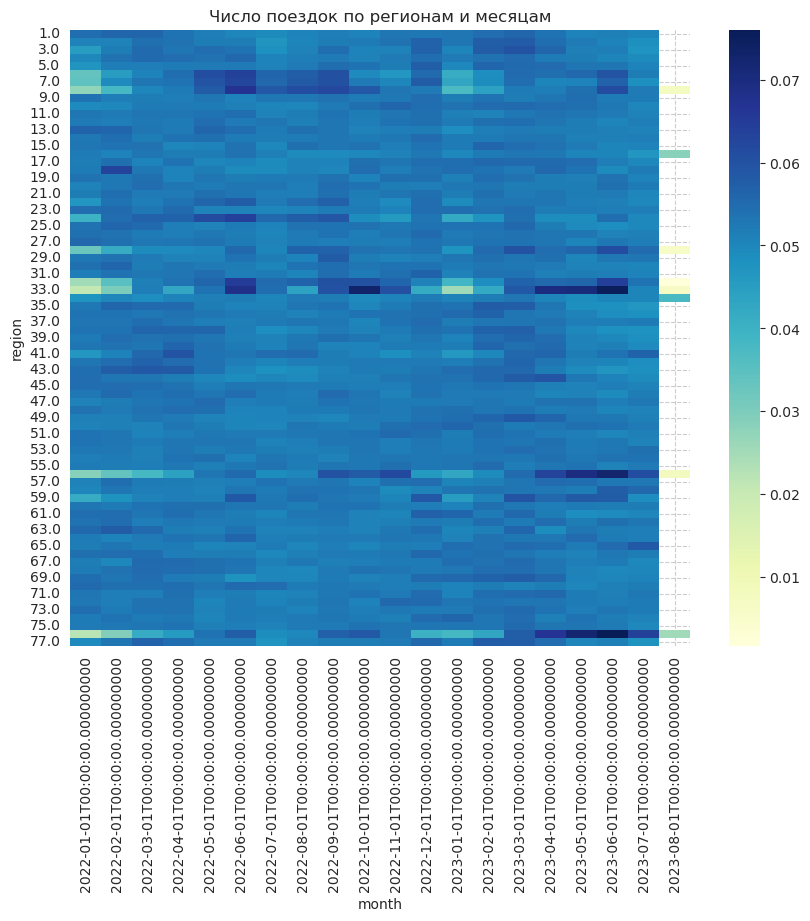

In [44]:
plot_by_region(month_by_region, 'month', 'trips', 'Число поездок по регионам и месяцам')

Видны явные отличия на некоторых районах. Например 56 и 76 - это аэропорты.

#### Trip miles

In [45]:
trip_miles_sample = df_union.select('Trip Miles').sample(0.005).toPandas()

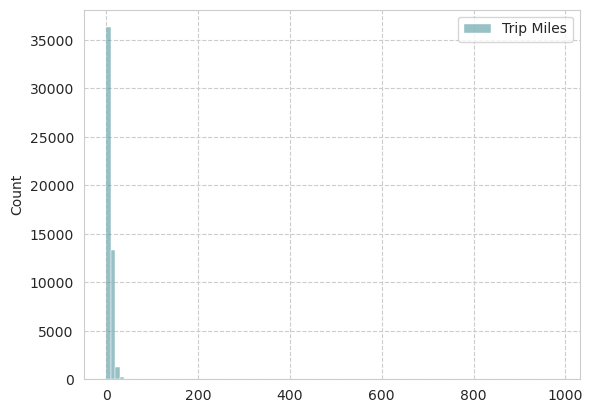

In [46]:
sns.histplot(trip_miles_sample, bins=100, palette='crest');

In [47]:
trip_miles_sample.describe()

Trip Miles
count  51182.000000
mean       6.278599
std        8.811368
min        0.000000
25%        0.870000
50%        2.700000
75%       11.300000
max      982.000000

Выборка из 50 тыс строк. Видно что есть поездки с нулевым расстоянием. Возможно это отмененные заказы.

In [48]:
query = """
    SELECT COUNT(`Trip ID`) as num_zero_miles
    FROM table_data
    WHERE `Trip Miles` = 0
"""
res = spark.sql(query)

In [49]:
res.show()

+--------------+
|num_zero_miles|
+--------------+
|       1197497|
+--------------+



Болee миллиона записей с нулевой дистанцией поездки. Это более 10% от всех поездок. Нужно будет учитывать данный факт при дальнейшем исследовании данных. Так как нет данных о причинах отмены, отмененные поездки можем оставить как есть, т.к. в любом случае это полезные данные.

In [50]:
query = """
    SELECT AVG(`Trip Miles`) as avg_miles,
           MEDIAN(`Trip Miles`) as median_miles,
           `Pickup Community Area` as region
    FROM table_data
    WHERE `Trip Miles` > 0
    GROUP BY region
    ORDER BY region
"""
res = spark.sql(query)

In [51]:
trip_miles = res.toPandas().dropna()

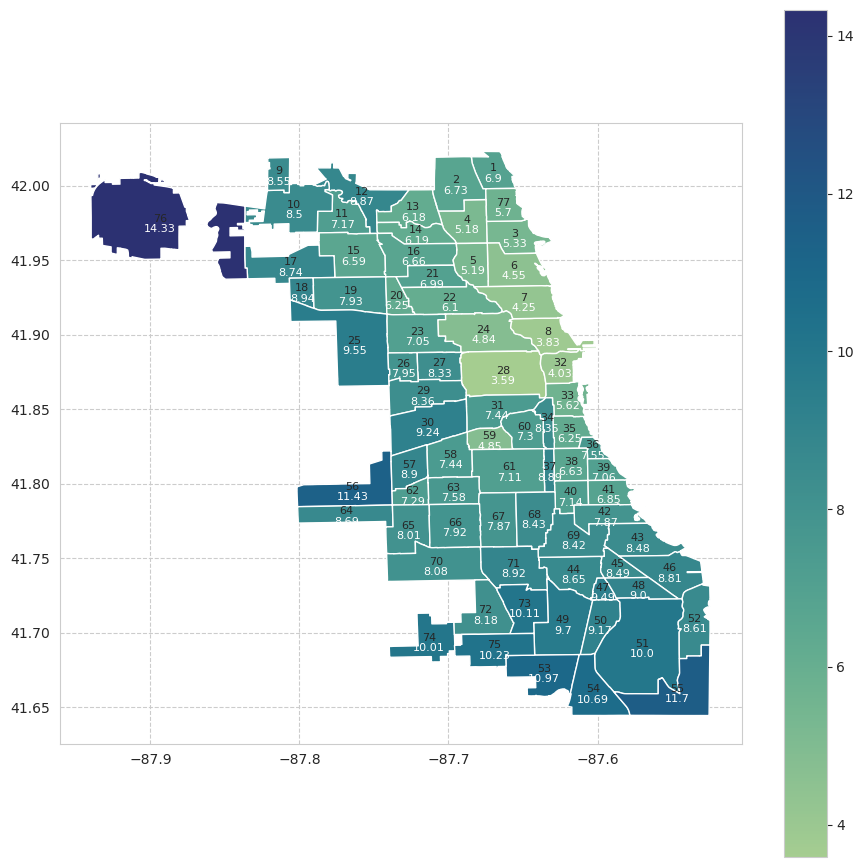

In [52]:
plot_on_map(geo_df, trip_miles, 'avg_miles')

#### Trip minutes

Переведем секунды в минуты для более удобного восприятия

In [53]:
trip_minutes_sample = df_union.select('Trip Seconds').sample(0.005).toPandas() / 60

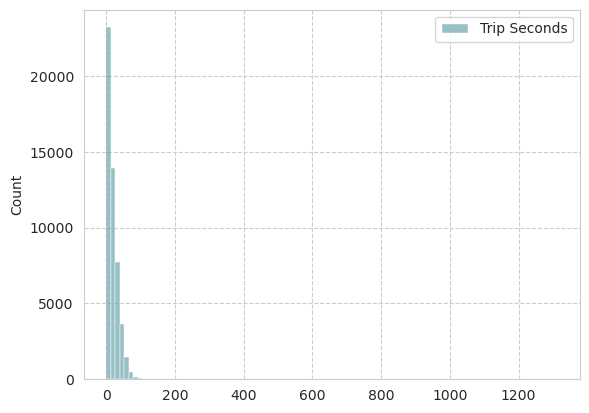

In [54]:
sns.histplot(trip_minutes_sample, bins=100, palette='crest');

In [55]:
trip_minutes_sample.describe()

Trip Seconds
count  50832.000000
mean      19.982452
std       25.948880
min        0.000000
25%        7.750000
50%       14.933333
75%       27.583333
max     1312.100000

In [56]:
query = """
    SELECT COUNT(`Trip ID`) as num_zero_seconds
    FROM table_data
    WHERE `Trip Seconds` = 0
"""
res = spark.sql(query)

In [57]:
res.show()

+----------------+
|num_zero_seconds|
+----------------+
|          231107|
+----------------+



Поездок с нулевым количеством секунд меньше, чем поездок с нулевой дистанцией. Можем предположить, что случаи с нулевым временем - заказы сделанные по ошибке.

Что касается очень длинных поездок (более 10 часов):

In [58]:
query = """
    SELECT COUNT(`Trip ID`) as num_zero_seconds
    FROM table_data
    WHERE `Trip Seconds` > 36000
"""
res = spark.sql(query)
res.show()

+----------------+
|num_zero_seconds|
+----------------+
|            7382|
+----------------+



Таких поездок менее 0.1%. Это могут быть действительно длинные поездки, либо например ошибочно не выключенный счетчик. Таких данных гораздо меньше, чем например нулевых дистаций поездок.

In [59]:
query = """
    SELECT AVG(`Trip Seconds`) / 60 as avg_minutes,
           MEDIAN(`Trip Seconds`) / 60 as median_minutes,
           `Pickup Community Area` as region
    FROM table_data
    WHERE `Trip Miles` > 0
    GROUP BY region
    ORDER BY region
"""
res = spark.sql(query)

In [60]:
trip_minutes = res.toPandas().dropna()

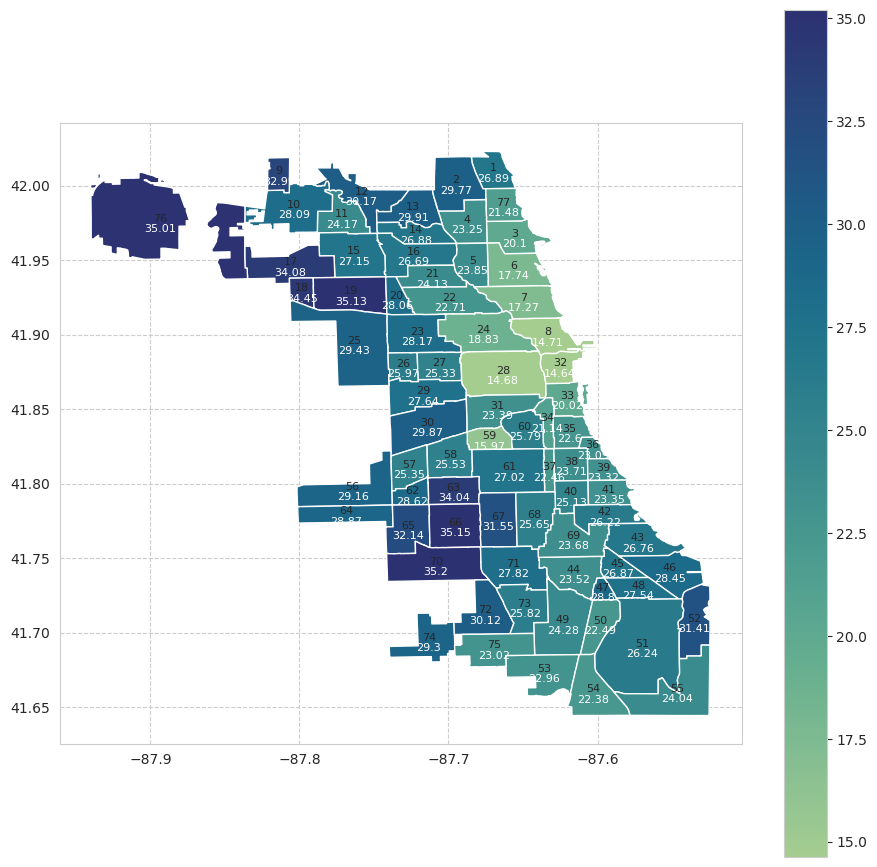

In [61]:
plot_on_map(geo_df, trip_minutes, 'avg_minutes')

#### Destinations

In [62]:
query = """
    SELECT MODE(`Dropoff Community Area`) as destination,
           `Pickup Community Area` as region
    FROM table_data
    WHERE `Trip Miles` > 0
    GROUP BY region
    ORDER BY region
"""
res = spark.sql(query)

In [63]:
top_destination = res.toPandas().dropna()

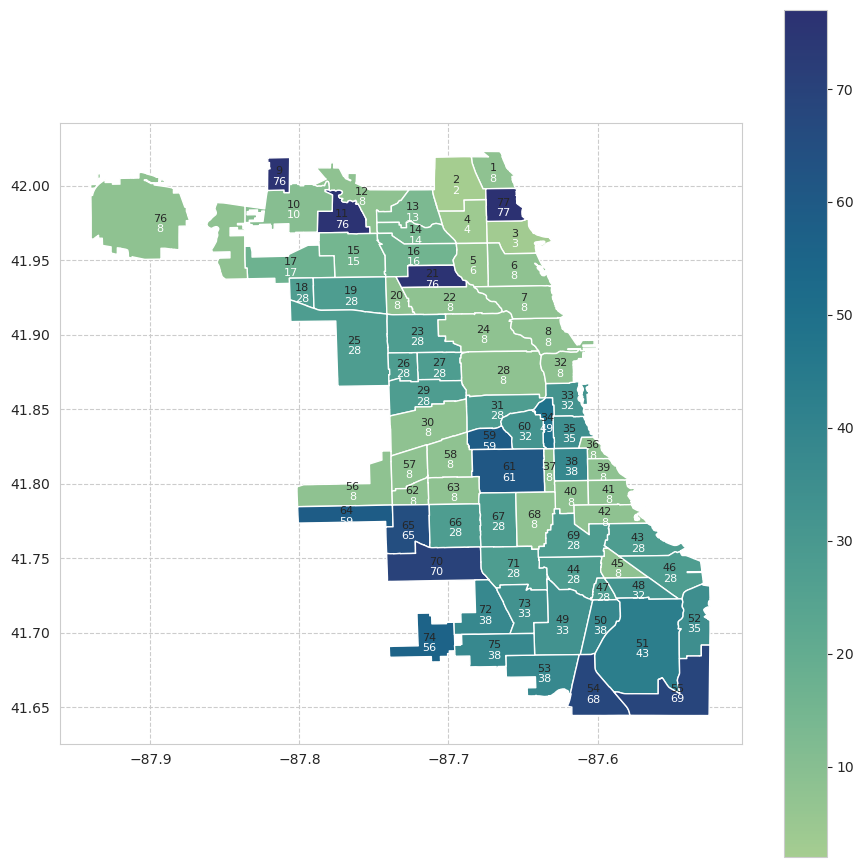

In [64]:
plot_on_map(geo_df, top_destination, 'destination')

Самый популярный район - номер 8.

#### Fare

In [65]:
fares = df_union.select('Fare').sample(0.001).toPandas()

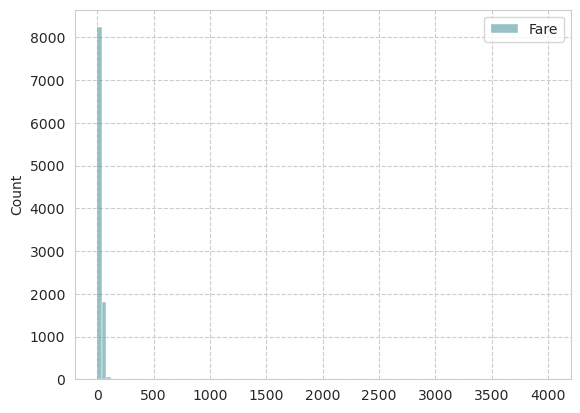

In [66]:
sns.histplot(data=fares, bins=100, palette='crest');

In [67]:
fares.describe()

Fare
count  10102.000000
mean      22.209552
std       47.126720
min        0.000000
25%        8.000000
50%       14.000000
75%       33.750000
max     4000.090000

In [68]:
query = """
    SELECT Count(`Trip ID`) as zero_fare
    FROM table_data
    WHERE `Fare` = 0
"""
res = spark.sql(query)
res.show()

+---------+
|zero_fare|
+---------+
|     9088|
+---------+



In [69]:
query = """
    SELECT AVG(`Fare`) as fare,
           `Pickup Community Area` as region
    FROM table_data
    WHERE `Trip Miles` > 0
    GROUP BY region
    ORDER BY region
"""
res = spark.sql(query)

In [70]:
avg_fares = res.toPandas().dropna()

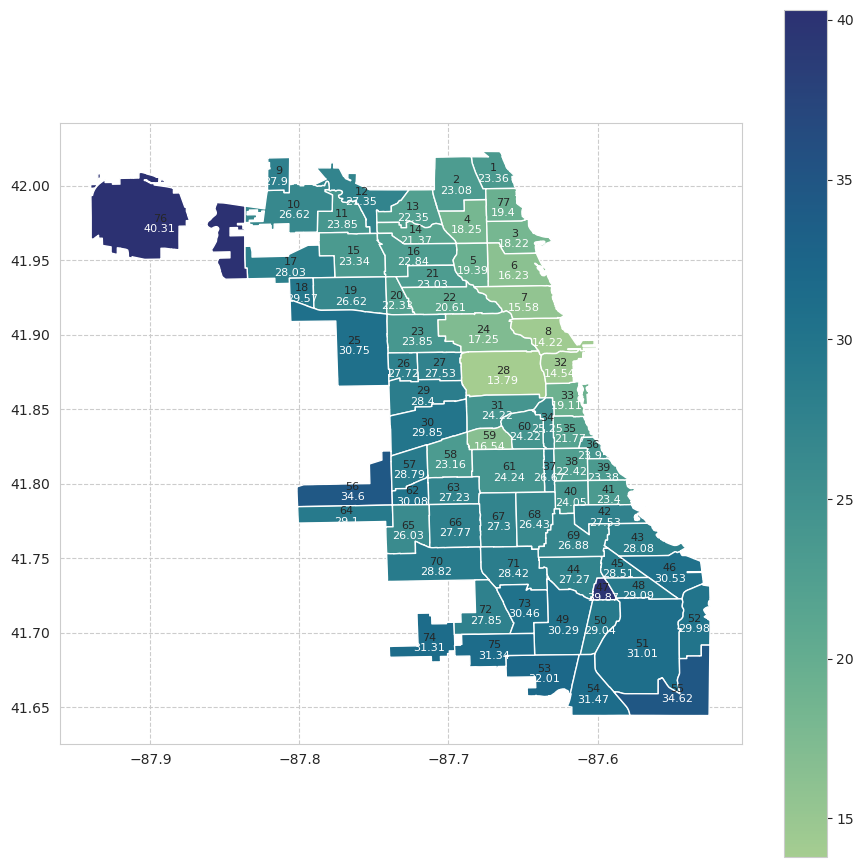

In [71]:
plot_on_map(geo_df, avg_fares, 'fare')

#### Население

In [72]:
population = pd.read_csv('external_data/chicago_population.csv', sep=';').T

In [73]:
header_pop = population.iloc[0]
population = population.iloc[1:]
population.columns = header_pop

In [74]:
population['region'] = population.index

In [75]:
population.columns

Index(['name', 'population', 'income', 'latinos', 'blacks', 'white', 'asian',
       'other', 'region'],
      dtype='object', name='Community Area')

In [76]:
population[['population', 'income', 'latinos', 
            'blacks', 'white', 'asian', 'other']] = population[['population', 'income', 'latinos', 
                                                                'blacks', 'white', 'asian', 'other']].apply(pd.to_numeric)

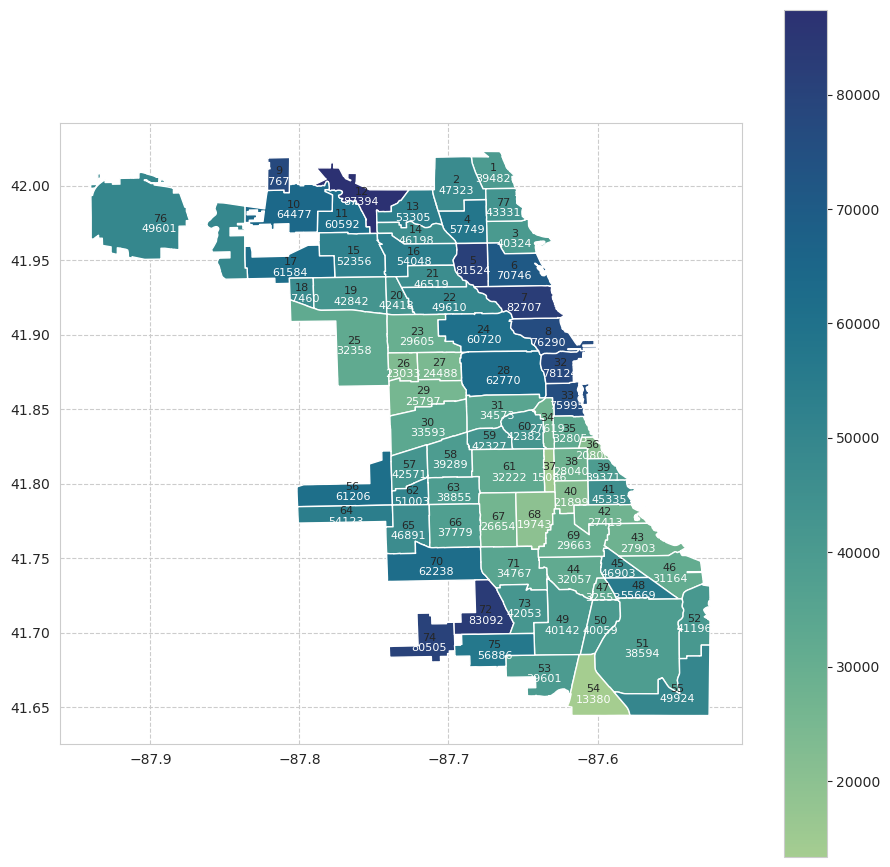

In [77]:
plot_on_map(geo_df, population, 'income')

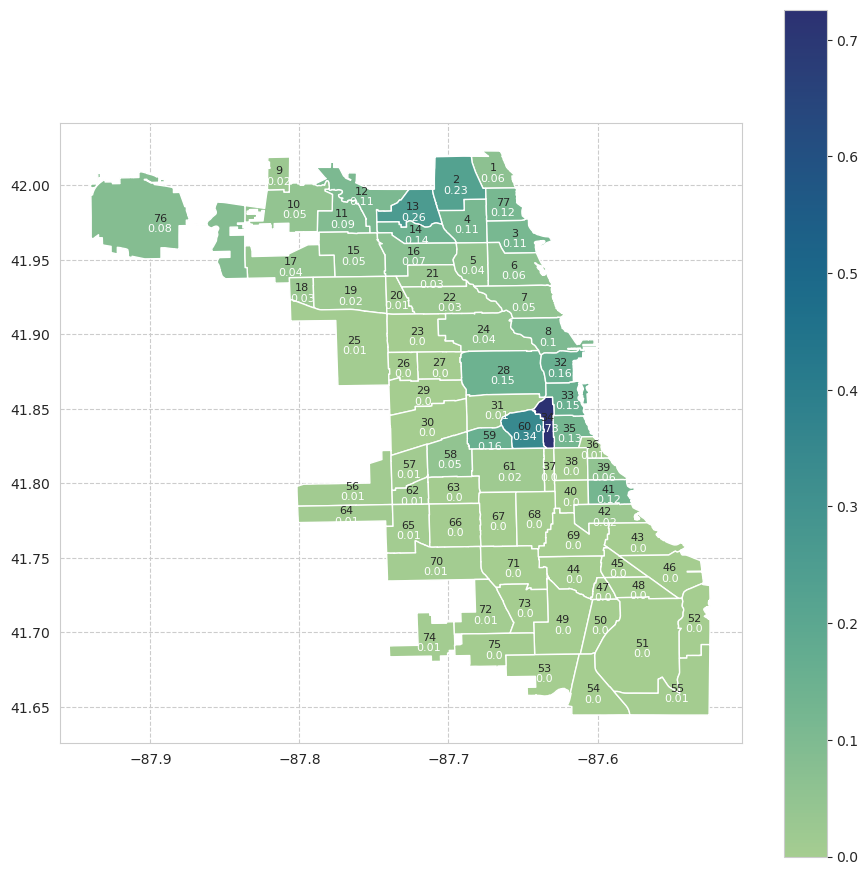

In [78]:
plot_on_map(geo_df, population, 'asian')

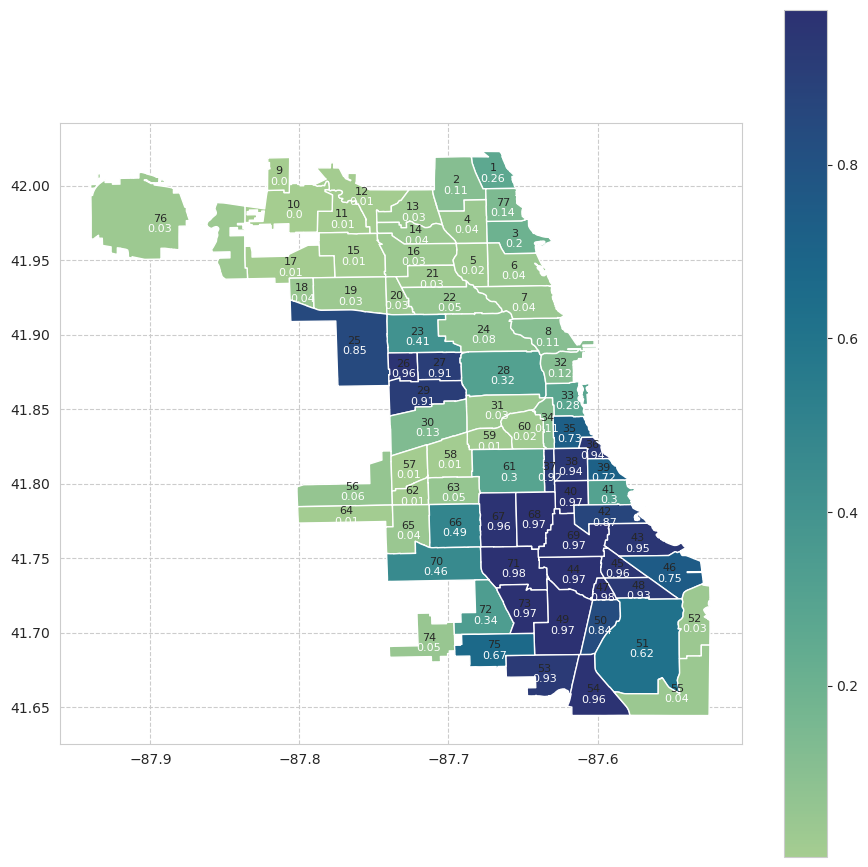

In [79]:
plot_on_map(geo_df, population, 'blacks')

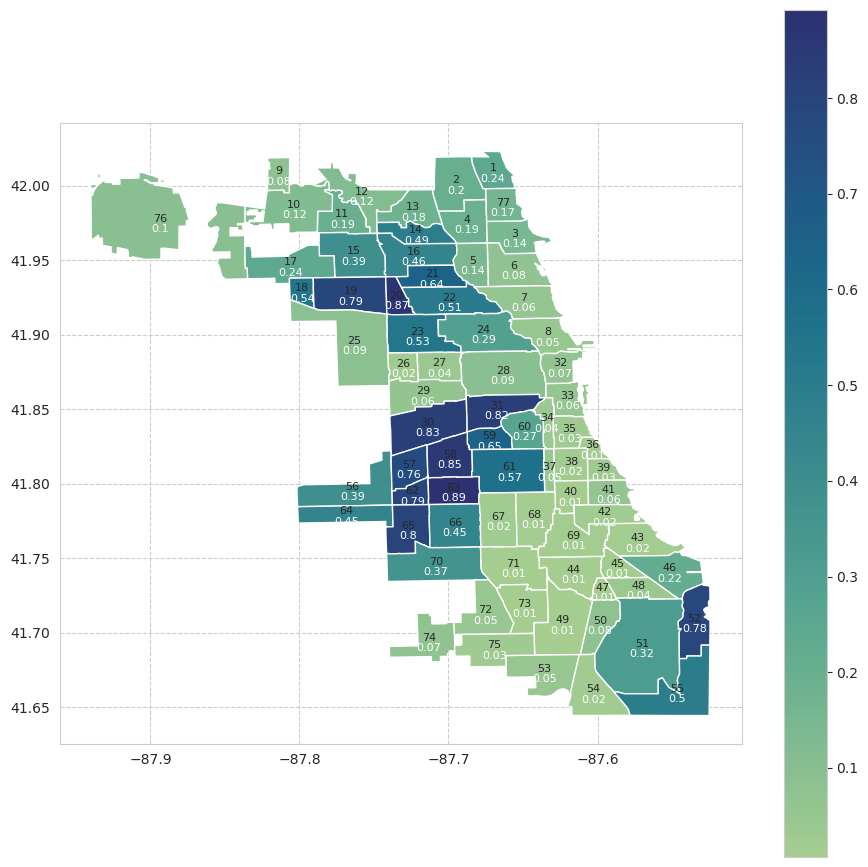

In [80]:
plot_on_map(geo_df, population, 'latinos')

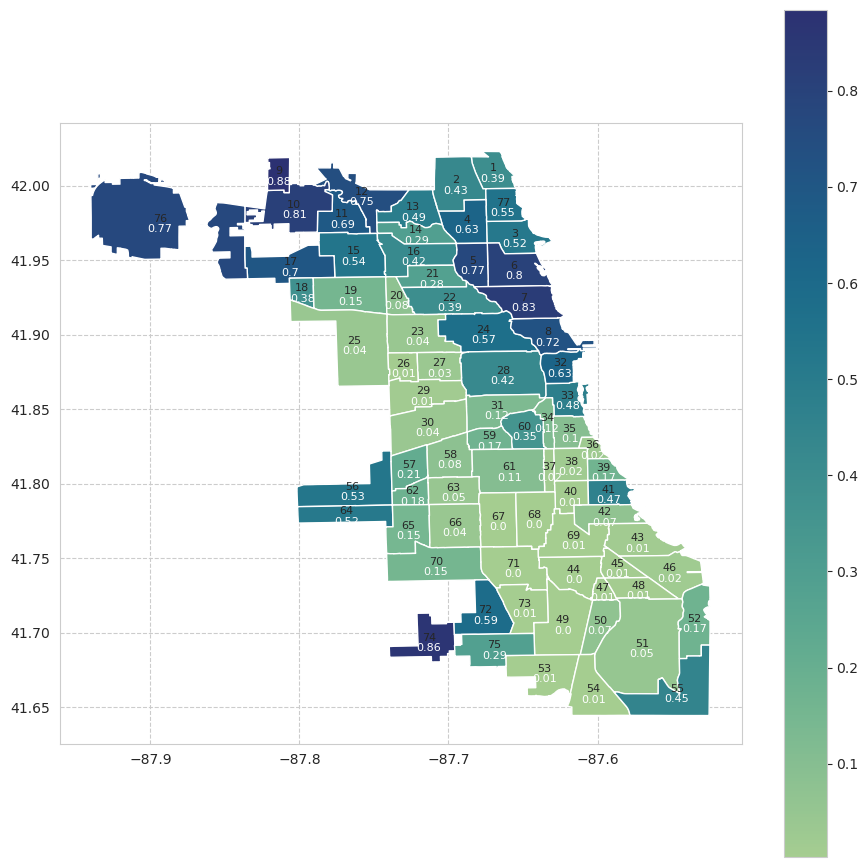

In [81]:
plot_on_map(geo_df, population, 'white')

### Подготовка данных

Будем агрегировать данные по часу. Сначала сделаем сводную таблицу. Так как возможно есть часы, за которые не совершено ни одной поездки, то в сводной таблице будут пропуски. Заполним их нулями. Также удалим столбец с поездками, регион которых оказался незаполнен (загородные поездки).

In [82]:
agg_data = df_union.groupBy(
    F.date_trunc('hour', F.to_timestamp('Trip Start Timestamp', 'MM/dd/yyyy hh:mm:ss a')).alias('timestamp')
                            ).pivot('Pickup Community Area').agg({'Trip ID': 'count'}).alias('rides')\
                             .orderBy('timestamp').fillna(0).drop('null')

agg_data.count()

Строк меньше чем должно было бы быть. Вероятно, что в году был такой час, за который не было совершено ни одной поездки, поэтому он не попал в данные. Поступим следующим образом - сгенерируем датафрейм с колонкой последовательных дат от минимальной до максимальной для наших данных и присоединим к нему аггрегированный датафрейм и заполним пустые строчки нулями.

In [83]:
# Определим минимальную и максимальную даты и заключим в одинарные кавычки для вставки в функцию to_datetime
min_date = f"'{agg_data.agg({'timestamp': 'min'}).collect()[0][0].strftime('%Y-%m-%d %H:%M:%S')}'"
max_date = f"'{agg_data.agg({'timestamp': 'max'}).collect()[0][0].strftime('%Y-%m-%d %H:%M:%S')}'"

In [84]:
min_date, max_date

("'2022-01-01 00:00:00'", "'2023-08-01 00:00:00'")

In [85]:
# Создаем последовательность дат
df_dates = spark.range(1).select(
    F.expr(f"sequence(to_timestamp({min_date}), to_timestamp({max_date}), interval 1 hour)").alias("date_hour")
).selectExpr("explode(date_hour) as timestamp")

In [86]:
# Теперь присоединим агрегированные данные к последовательности дат и заполним пустые значениями нулями, т.к. в пропущенные часы поездок не было.
date_agg = df_dates.join(agg_data, on='timestamp', how='left').fillna(0)

Теперь пересоберем датафрейм с колонкой по регионам

In [87]:
col_names = list(map(str, (range(1, 78))))

In [88]:
df_melted = agg_data.melt(ids=['timestamp'], values=col_names, variableColumnName="region", valueColumnName="rides")

### Feature Engineering

#### Характеристики даты и времени

In [89]:
df_features = (
    df_melted.withColumn("hour_of_day", F.hour("timestamp"))
             .withColumn("day_of_week", F.dayofweek("timestamp"))
             .withColumn("day_of_month", F.dayofmonth("timestamp"))
             .withColumn("day_of_year", F.dayofyear("timestamp"))
             .withColumn("week_of_year", F.weekofyear("timestamp"))
             .withColumn("month_of_year", F.month("timestamp"))
             .withColumn("quarter_of_year", F.quarter("timestamp"))
)

#### Тригонометрическая форма

Произведем тригонометрические преобразования для циклических признаков.

In [90]:
df_features = df_features.withColumn("hour_sin", F.sin(F.radians(df_features["hour_of_day"] * (360 / 24)))) \
                         .withColumn("hour_cos", F.cos(F.radians(df_features["hour_of_day"] * (360 / 24)))) \
                         .withColumn("dow_sin", F.sin(F.radians(df_features["day_of_week"] * (360 / 7)))) \
                         .withColumn("dow_cos", F.cos(F.radians(df_features["day_of_week"] * (360 / 7)))) \
                         .withColumn("dom_sin", F.sin(F.radians(df_features["day_of_month"] * (360 / 31)))) \
                         .withColumn("dom_cos", F.cos(F.radians(df_features["day_of_month"] * (360 / 31)))) \
                         .withColumn("doy_sin", F.sin(F.radians(df_features["day_of_year"] * (360 / 365)))) \
                         .withColumn("doy_cos", F.cos(F.radians(df_features["day_of_year"] * (360 / 365)))) \
                         .withColumn("woy_sin", F.sin(F.radians(df_features["week_of_year"] * (360 / 52)))) \
                         .withColumn("woy_cos", F.cos(F.radians(df_features["week_of_year"] * (360 / 52)))) \
                         .withColumn("moy_sin", F.sin(F.radians(df_features["month_of_year"] * (360 / 12)))) \
                         .withColumn("moy_cos", F.cos(F.radians(df_features["month_of_year"] * (360 / 12)))) \
                         .withColumn("qoy_sin", F.sin(F.radians(df_features["quarter_of_year"] * (360 / 4)))) \
                         .withColumn("qoy_cos", F.cos(F.radians(df_features["quarter_of_year"] * (360 / 4))))

#### Лаги

In [91]:
windowSpec = Window.partitionBy("region").orderBy("timestamp")
df_features = df_features.withColumn("lag_1h", F.lag("rides", 1).over(windowSpec)) \
                        .withColumn("lag_2h", F.lag("rides", 2).over(windowSpec)) \
                        .withColumn("lag_23h", F.lag("rides", 23).over(windowSpec)) \
                        .withColumn("lag_1d", F.lag("rides", 24).over(windowSpec)) \
                        .withColumn("lag_2d", F.lag("rides", 48).over(windowSpec)) \
                        .withColumn("lag_1w", F.lag("rides", 168).over(windowSpec))

#### Скользящее среднее

In [92]:
# В расчет скользящего среднего включаем только значения за предыдущие отрезки времени
window_3h = Window.partitionBy("region").orderBy(F.col("timestamp")).rowsBetween(-3, -1)
window_6h = Window.partitionBy("region").orderBy(F.col("timestamp")).rowsBetween(-6, -1)
window_12h = Window.partitionBy("region").orderBy(F.col("timestamp")).rowsBetween(-12, -1)
window_24h = Window.partitionBy("region").orderBy(F.col("timestamp")).rowsBetween(-24, -1)
window_48h = Window.partitionBy("region").orderBy(F.col("timestamp")).rowsBetween(-48, -1)
window_168h = Window.partitionBy("region").orderBy(F.col("timestamp")).rowsBetween(-168, -1)

df_features = df_features.withColumn("rolling_avg_3h", F.avg("rides").over(window_3h)) \
                        .withColumn("rolling_avg_6h", F.avg("rides").over(window_6h)) \
                        .withColumn("rolling_avg_12h", F.avg("rides").over(window_12h)) \
                        .withColumn("rolling_avg_24h", F.avg("rides").over(window_24h)) \
                        .withColumn("rolling_avg_48h", F.avg("rides").over(window_48h)) \
                        .withColumn("rolling_avg_168h", F.avg("rides").over(window_168h)).dropna()

#### Скользящие средние в разрезах по временным периодам

In [93]:
# Определение окна для расчета тридцатидневного скользящего среднего в разрезе по часам
window_spec = Window.partitionBy("region", "hour_of_day").orderBy("timestamp").rowsBetween(-30, -1)
# Расчет скользящего среднего
df_features = df_features.withColumn("moving_avg_30days", F.avg("rides").over(window_spec))

# Определение окна для расчета скользящего среднего в разрезе по часам и дням недели по четырем предыдущим периодам
window_spec = Window.partitionBy("region", "day_of_week", "hour_of_day").orderBy("timestamp").rowsBetween(-4, -1)
# Расчет скользящего среднего
df_features = df_features.withColumn("moving_avg_dow_hour_4", F.avg("rides").over(window_spec))

window_spec = Window.partitionBy("region", "day_of_week", "hour_of_day").orderBy("timestamp").rowsBetween(-8, -1)
df_features = df_features.withColumn("moving_avg_dow_hour_8", F.avg("rides").over(window_spec))

#### Внешние данные

#### Праздники и выходные

Подгрузим данные о праздничных днях. Так как 
Также можно отдельно маркировать день перед нерабочими днями и непосредственно после них.  
Еще - длинные выходные и дни школьных каникул.

In [94]:
holidays2022 = spark.read.csv('external_data/us-holidays-2022.csv', sep=';', header=True, inferSchema=True)

In [95]:
holidays2023 = spark.read.csv('external_data/us-holidays-2023.csv', sep=';', header=True, inferSchema=True)

In [96]:
holidays_22_23 = holidays2022.union(holidays2023)

In [97]:
data_holidays = holidays_22_23.withColumn('date', F.to_timestamp(F.col('date'), 'MMMM d, yyyy')) \
                              .withColumn('is_holiday', F.lit(1))['date', 'is_holiday']

Для присоединения признаков по дате введем дополнительную колонку в датафрейм с фичами - date

In [98]:
df_features = df_features.withColumn('date', F.date_trunc('day', F.col('timestamp'))).join(data_holidays, on='date', how='left').fillna(0)

Введем в данные столбец 'working_day', которая обозначает рабочие дни как 1 и как 0 выходные и праздничные дни.

In [99]:
df_features = df_features.withColumn("working_day", 
                                     F.when((df_features["is_holiday"] == 1) | (df_features["day_of_week"].isin(["6", "7"])), 0).otherwise(1))

Данные по школьным каникулам

In [100]:
school_holidays = spark.read.csv('external_data/pub_sc_holidays.csv', header=True, inferSchema=True)

In [101]:
school_holidays = school_holidays.withColumn('date', F.to_timestamp(F.col('date'), 'yyyy-mm-dd'))

In [102]:
df_features = df_features.join(school_holidays, on='date', how='left')

#### Погода

Подгрузим информацию с архивными данными о погоде. Данные взяты через api сайта open-meteo.com по каждому из регионов. В качестве географических координат для брался центроид региона.

In [103]:
weather_arc_daily = spark.read.csv('external_data/daily_weather_arc.csv', header=True, inferSchema=True)

In [104]:
weather_arc_daily = weather_arc_daily.withColumn("region", F.col('region').cast(StringType())) \
                                     .withColumn("date", F.to_timestamp(F.col('time')))[
    'temperature_2m_mean', 'apparent_temperature_mean', 'sunrise', 'sunset',
    'precipitation_sum', 'rain_sum', 'snowfall_sum', 'region', 'date'
]

In [105]:
weather_arc_hourly = spark.read.csv('external_data/hourly_weather_arc.csv', header=True, inferSchema=True)
weather_arc_hourly = weather_arc_hourly[
    'temperature_2m', 'relativehumidity_2m', 'apparent_temperature', 'precipitation',
    'rain', 'snowfall', 'cloudcover', 'cloudcover_low', 'windspeed_10m', 'region', 'time'
]

In [106]:
weather_arc_hourly = weather_arc_hourly.withColumn("region", F.col('region').cast(StringType())) \
                                       .withColumn("timestamp", F.col('time')).drop('_c0', 'time')

In [107]:
df_features = df_features.join(weather_arc_hourly, on=['timestamp', 'region'], how='left') \
                         .join(weather_arc_daily, on=['date', 'region'], how='left')

In [108]:
windowSpec = Window.partitionBy("region").orderBy("timestamp")
df_features = df_features.withColumn("temperature_2m_lag_1h", F.lag('temperature_2m', 1).over(windowSpec)) \
                         .withColumn("apparent_temperature_lag_1h", F.lag('apparent_temperature', 1).over(windowSpec)) \
                         .withColumn("precipitation_lag_1h", F.lag('precipitation', 1).over(windowSpec)) \
                         .withColumn("rain_lag_1h", F.lag('rain', 1).over(windowSpec)) \
                         .withColumn("snowfall_lag_1h", F.lag('snowfall', 1).over(windowSpec)) \
                         .withColumn("cloudcover_lag_1h", F.lag('cloudcover', 1).over(windowSpec)) \
                         .withColumn("windspeed_10m_lag_1h", F.lag('windspeed_10m', 1).over(windowSpec))

df_features = df_features.drop('relativehumidity_2m', 'cloudcover', 'cloudcover_low', 'windspeed_10m')

In [109]:
df_features = df_features.withColumn("apparent_temperature_mean_lag_1d", F.lag('apparent_temperature_mean', 24).over(windowSpec)) \
                         .withColumn("temperature_mean_lag_1d", F.lag('temperature_2m_mean', 24).over(windowSpec)) \
                         .withColumn("precipitation_sum_lag_1d", F.lag('precipitation_sum', 24).over(windowSpec)) \
                         .withColumn("rain_sum_lag_1d", F.lag('rain_sum', 24).over(windowSpec)) \
                         .withColumn("snowfall_sum_lag_1d", F.lag('snowfall_sum', 24).over(windowSpec)).dropna()

In [110]:
df_features = df_features.withColumn(
    "is_daylight", 
    F.when((df_features["timestamp"] >= df_features["sunrise"]) & 
           (df_features["timestamp"] <= df_features["sunset"]), 1).otherwise(0)
)

In [111]:
# Отбрасываем не нужные больше вспомогательные колонки
df_features = df_features.drop('quarter_of_year', 'date', 'sunrise', 'sunset', 
                               'precipitation_sum', 'rain_sum', 'snowfall_sum')

У нас в наличии информация о температуре, относительной влажности, ощущаемой температуре, осадках, отдельно дождь / снег, скрость ветра на высоте 10 и 100м и др. Можем использовать в качестве признаков данные о погоде за предыдущий час. Так как сейчас довольно точные прогнозы погоды, особенно в пределах ближайших часов, то можем использовать дынные о погоде и за текущий час.  
Кроме того есть агрегированные данные о погоде по дням. Можем использовать эти данные аналогично. Также есть данные о времени восхода/заката. Отсюда можем создать признак, который будет покзаывать темно на улице или нет.

### Train Test Split

#### Разделение данных на выборки для распределенных моделей Spark ML

In [112]:
# Определяем номер строки внутри каждой группы
windowSpec = Window.partitionBy("region").orderBy("timestamp")
df_with_rownum = df_features.withColumn("rownum", F.row_number().over(windowSpec))
df_with_maxrow = df_with_rownum.withColumn("maxrow", F.max("rownum").over(Window.partitionBy("region")))

# Разделяем на обучающую, валидационную и тестовую выборки
train = df_with_maxrow.where(F.col("rownum") <= 0.6 * F.col("maxrow")).select(df_features.columns)
valid = df_with_maxrow.where((F.col("rownum") > 0.6 * F.col("maxrow")) & (F.col("rownum") <= 0.8 * F.col("maxrow"))).select(df_features.columns)
test = df_with_maxrow.where(F.col("rownum") > 0.8 * F.col("maxrow")).select(df_features.columns)

In [113]:
train = train.repartition(154, 'region')
valid = valid.repartition(154, 'region')
test = test.repartition(154, 'region')

In [114]:
train.cache()
valid.cache()
test.cache()

DataFrame[region: string, timestamp: timestamp, rides: bigint, hour_of_day: int, day_of_week: int, day_of_month: int, day_of_year: int, week_of_year: int, month_of_year: int, hour_sin: double, hour_cos: double, dow_sin: double, dow_cos: double, dom_sin: double, dom_cos: double, doy_sin: double, doy_cos: double, woy_sin: double, woy_cos: double, moy_sin: double, moy_cos: double, qoy_sin: double, qoy_cos: double, lag_1h: bigint, lag_2h: bigint, lag_23h: bigint, lag_1d: bigint, lag_2d: bigint, lag_1w: bigint, rolling_avg_3h: double, rolling_avg_6h: double, rolling_avg_12h: double, rolling_avg_24h: double, rolling_avg_48h: double, rolling_avg_168h: double, moving_avg_30days: double, moving_avg_dow_hour_4: double, moving_avg_dow_hour_8: double, is_holiday: int, working_day: int, is_sc_holiday: int, temperature_2m: double, apparent_temperature: double, precipitation: double, rain: double, snowfall: double, temperature_2m_mean: double, apparent_temperature_mean: double, temperature_2m_lag_1h:

#### Разделение данных на выборки для моделей PandasUDF

Здесь применим другой подход. Введем в датафрейм столбце 'dataset', где в завивимости от принадлежности данных к той или иной выбрке будем писать 'train', 'val' или 'test'.

In [115]:
# Определяем номер строки внутри каждой группы
windowSpec = Window.partitionBy("region").orderBy("timestamp")
df_with_rownum = df_features.withColumn("rownum", F.row_number().over(windowSpec))
df_with_maxrow = df_with_rownum.withColumn("maxrow", F.max("rownum").over(Window.partitionBy("region")))

# Разделяем выборки на train, val и test в соотношении 0.6 : 0.2 : 0.2
data_split = df_with_maxrow.withColumn(
    'dataset',
    F.when(F.col("rownum") <= 0.6 * F.col("maxrow"), "train")
    .when(F.col("rownum") <= 0.8 * F.col("maxrow"), "val")
    .otherwise("test")
).drop("rownum", "maxrow")

In [116]:
data_split = data_split.repartition(154, 'region')

In [117]:
data_split.cache()

DataFrame[region: string, timestamp: timestamp, rides: bigint, hour_of_day: int, day_of_week: int, day_of_month: int, day_of_year: int, week_of_year: int, month_of_year: int, hour_sin: double, hour_cos: double, dow_sin: double, dow_cos: double, dom_sin: double, dom_cos: double, doy_sin: double, doy_cos: double, woy_sin: double, woy_cos: double, moy_sin: double, moy_cos: double, qoy_sin: double, qoy_cos: double, lag_1h: bigint, lag_2h: bigint, lag_23h: bigint, lag_1d: bigint, lag_2d: bigint, lag_1w: bigint, rolling_avg_3h: double, rolling_avg_6h: double, rolling_avg_12h: double, rolling_avg_24h: double, rolling_avg_48h: double, rolling_avg_168h: double, moving_avg_30days: double, moving_avg_dow_hour_4: double, moving_avg_dow_hour_8: double, is_holiday: int, working_day: int, is_sc_holiday: int, temperature_2m: double, apparent_temperature: double, precipitation: double, rain: double, snowfall: double, temperature_2m_mean: double, apparent_temperature_mean: double, temperature_2m_lag_1h:

### Признаки

Определим признаки для обучения моделей и будем использовать одинаковый набор признаков на всех моделях.

In [118]:
feature_cols = ['hour_of_day', 'day_of_week', 'day_of_month', 'day_of_year', 'week_of_year',
                'month_of_year', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'dom_sin',
                'dom_cos', 'doy_sin', 'doy_cos', 'woy_sin', 'woy_cos', 'moy_sin', 'moy_cos',
                'qoy_sin', 'qoy_cos', 'lag_1h', 'lag_2h', 'lag_23h', 'lag_1d', 'lag_2d',
                'lag_1w', 'rolling_avg_3h', 'rolling_avg_6h', 'rolling_avg_12h',
                'rolling_avg_24h', 'rolling_avg_48h', 'rolling_avg_168h', 'moving_avg_30days',
                'moving_avg_dow_hour_4', 'moving_avg_dow_hour_8', 'is_holiday', 'working_day',
                'is_sc_holiday', 'temperature_2m', 'apparent_temperature', 'precipitation',
                'rain', 'snowfall', 'temperature_2m_mean', 'apparent_temperature_mean',
                'temperature_2m_lag_1h', 'apparent_temperature_lag_1h', 'precipitation_lag_1h',
                'rain_lag_1h', 'snowfall_lag_1h', 'cloudcover_lag_1h', 'windspeed_10m_lag_1h',
                'apparent_temperature_mean_lag_1d', 'temperature_mean_lag_1d',
                'precipitation_sum_lag_1d', 'rain_sum_lag_1d', 'snowfall_sum_lag_1d', 'is_daylight']

### Обучение нескольких регионов одной моделью

#### Функции для расчетов метрик

In [119]:
def compute_smape_with_epsilon(predictions_df, epsilon=1e-10):
    # Добавляем epsilon к знаменателю для стабильности
    smape_df = predictions_df.withColumn(
        "smape_component", 
        2 * F.abs(F.col("prediction") - F.col("rides")) / (F.abs(F.col("prediction")) + F.abs(F.col("rides")) + epsilon)
    )

    # Вычисляем среднее значение
    smape = smape_df.agg({"smape_component": "avg"}).collect()[0][0] * 100

    return smape

Средняя абсолютная масштабированная ошибка

In [120]:
def compute_mase(predictions_df):
    # Вычисляем MAE для модели
    model_mae = predictions_df.withColumn("error", F.abs(F.col("prediction") - F.col("rides"))).agg(F.avg("error")).collect()[0][0]
    
    # Вычисляем MAE для наивного прогноза
    naive_mae = predictions_df.withColumn("naive_error", F.abs(F.col("rides") - F.col("lag_1h"))).agg(F.avg("naive_error")).collect()[0][0]
    
    # Считаем MASE
    mase = model_mae / naive_mae
    return mase

#### Linear Regression (Elastic Net) + настройка гиперпараметров в Hyperopt

In [121]:
# Векторизация признаков
vec_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_vec = vec_assembler.transform(train)
valid_vec = vec_assembler.transform(valid)
test_vec = vec_assembler.transform(test)

In [122]:
# Определяем пространство настраиваемых параметров
space = {
    'elasticNetParam': hp.uniform('elasticNetParam', 0, 1),
    'regParam': hp.loguniform('regParam', -5, 0)
}

In [123]:
# Для работы spark модели нужно чтобы целевой столбец назывался 'label'. Добавляем столбец с этим именем.
train_vec_label = train_vec.withColumn('label', F.col('rides'))
valid_vec_label = valid_vec.withColumn('label', F.col('rides'))
test_vec_label = test_vec.withColumn('label', F.col('rides'))

In [124]:
def objective(params):
    # Обучение модели
    lr = LinearRegression(elasticNetParam=params['elasticNetParam'], 
                          regParam=params['regParam'],
                          standardization=True)
    model = lr.fit(train_vec_label)
    predictions = model.transform(valid_vec_label)
    y_true = np.array(predictions.select('rides').rdd.flatMap(lambda x: x).collect())
    y_pred = np.array(predictions)
    
    # Вычисление ошибки (MAE, SMAPE, MASE)
    evaluator = RegressionEvaluator(labelCol="rides", predictionCol="prediction", metricName="mae")
    mae = evaluator.evaluate(predictions)
    smape = compute_smape_with_epsilon(predictions)
    mase = compute_mase(predictions)

    # Запишем параметры модели в соответствующие переменные
    coefficients = model.coefficients
    intercept = model.intercept
    
    # Документирование параметров и метрик с помощью mlflow
    with mlflow.start_run():
        mlflow.log_param("elasticNetParam", params['elasticNetParam'])
        mlflow.log_param("regParam", params['regParam'])
        for feature, value in zip(feature_cols, coefficients):
            mlflow.log_metric(feature, value)
        mlflow.log_metric('intercept', intercept)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("smape", smape)
        mlflow.log_metric('mase', mase)

    return {'loss': mae, 'status': STATUS_OK}

In [125]:
# Регитрируем эксперимент в MLFlow
mlflow.set_experiment("Spark_ElasticNet_Experiment")

2023/09/10 17:22:38 INFO mlflow.tracking.fluent: Experiment with name 'Spark_ElasticNet_Experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/mlflow_data/1', creation_time=1694366558147, experiment_id='1', last_update_time=1694366558147, lifecycle_stage='active', name='Spark_ElasticNet_Experiment', tags={}>

In [126]:
# Запуск оптимизации гиперпараметров
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=5, trials=trials)

100%|██████████| 5/5 [05:52<00:00, 70.49s/trial, best loss: 2.0660976201835326] 


#### !!! Evals num

In [127]:
best

{'elasticNetParam': 0.6483529892522086, 'regParam': 0.3947340901824018}

In [128]:
spark_lr = LinearRegression(**best)
spark_lr = spark_lr.fit(train_vec_label.union(valid_vec_label))

In [129]:
spark_lr_preds = spark_lr.transform(test_vec_label)

#### Постобработка

Так как мы предсказываем количество заказов, то следует избавиться от отрицательных значений в предсказаниях и округлить до целых

In [130]:
def post_processing_spark(spark_df):
    """
    Функция осуществляет постобработку. 
    Обнуляем отрицательные значения и округляем 
    до ближайшего среднего дробные предсказания.
    """
    output_df = spark_df.withColumn("prediction", F.greatest(F.col("prediction"), F.lit(0))) \
                        .withColumn('prediction', F.round(F.col('prediction')))
    output_df = output_df['region', 'rides', 'prediction', 'lag_1h']
    return output_df

In [131]:
spark_lr_preds.cache()

DataFrame[region: string, timestamp: timestamp, rides: bigint, hour_of_day: int, day_of_week: int, day_of_month: int, day_of_year: int, week_of_year: int, month_of_year: int, hour_sin: double, hour_cos: double, dow_sin: double, dow_cos: double, dom_sin: double, dom_cos: double, doy_sin: double, doy_cos: double, woy_sin: double, woy_cos: double, moy_sin: double, moy_cos: double, qoy_sin: double, qoy_cos: double, lag_1h: bigint, lag_2h: bigint, lag_23h: bigint, lag_1d: bigint, lag_2d: bigint, lag_1w: bigint, rolling_avg_3h: double, rolling_avg_6h: double, rolling_avg_12h: double, rolling_avg_24h: double, rolling_avg_48h: double, rolling_avg_168h: double, moving_avg_30days: double, moving_avg_dow_hour_4: double, moving_avg_dow_hour_8: double, is_holiday: int, working_day: int, is_sc_holiday: int, temperature_2m: double, apparent_temperature: double, precipitation: double, rain: double, snowfall: double, temperature_2m_mean: double, apparent_temperature_mean: double, temperature_2m_lag_1h:

In [132]:
spark_lr_preds = post_processing_spark(spark_lr_preds)

In [133]:
# Определите схему выходного DataFrame
schema = StructType([
    StructField("region", StringType(), True),
    StructField("MAE", DoubleType(), True),
    StructField("MAPE", DoubleType(), True),
    StructField("SMAPE", DoubleType(), True),
    StructField("MASE", DoubleType(), True)
])

In [134]:
# Функция для расчета метрик
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def compute_metrics(pdf: pd.DataFrame) -> pd.DataFrame:
    region = [pdf['region'].iloc[0]]
    y_true = pdf['rides']
    y_pred = pdf['prediction']
    y_pred_naive = pdf['lag_1h']
    
    mae = (y_true - y_pred).abs().mean()
    naive_mae = (y_true - y_pred_naive).abs().mean()
    epsilon = 1e-10
    mape = ((y_true - y_pred).abs() / (y_true + epsilon)).mean() * 100
    smape = np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2 + epsilon)) * 100
    mase = mae / naive_mae
    
    return pd.DataFrame({
        'region': region, 'MAE': [mae], 'MAPE': [mape],  
        'SMAPE': [smape], 'MASE': [mase]
    })

In [135]:
metrics_spark_lr = spark_lr_preds.groupBy("region").apply(compute_metrics).toPandas()

It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.


Смотрим статистику по прогнозам

In [136]:
metrics_spark_lr.describe()

MAE          MAPE      SMAPE       MASE
count  77.000000  7.700000e+01  77.000000  77.000000
mean    2.195383  1.833865e+11  62.516548   0.806613
std     4.559343  8.917658e+10  19.558947   0.053464
min     0.079168  1.899915e+01  14.860756   0.620739
25%     0.540679  1.189347e+11  48.197738   0.786559
50%     0.882525  1.962787e+11  67.366967   0.810202
75%     1.452390  2.488143e+11  76.201032   0.831129
max    27.596498  3.217804e+11  91.613882   1.063266

### XGBoost

In [137]:
# Инициализируем модель
spark_reg_estimator = SparkXGBRegressor(
    features_col="features",
    label_col="rides",
    num_workers=4,
)

Для градиентного бустинга в целях экономии вычислительных ресурсов подбирать гиперпараметры не будм. Поэтому будем сразу обучать на тестовой и валидационной выборке.

In [138]:
# Обучаем модель
xgb_model = spark_reg_estimator.fit(train_vec.union(valid_vec))
spark_xgb_preds = xgb_model.transform(test_vec)

Loading a native XGBoost model with Scikit-Learn interface.


In [139]:
spark_xgb_preds.cache()

DataFrame[region: string, timestamp: timestamp, rides: bigint, hour_of_day: int, day_of_week: int, day_of_month: int, day_of_year: int, week_of_year: int, month_of_year: int, hour_sin: double, hour_cos: double, dow_sin: double, dow_cos: double, dom_sin: double, dom_cos: double, doy_sin: double, doy_cos: double, woy_sin: double, woy_cos: double, moy_sin: double, moy_cos: double, qoy_sin: double, qoy_cos: double, lag_1h: bigint, lag_2h: bigint, lag_23h: bigint, lag_1d: bigint, lag_2d: bigint, lag_1w: bigint, rolling_avg_3h: double, rolling_avg_6h: double, rolling_avg_12h: double, rolling_avg_24h: double, rolling_avg_48h: double, rolling_avg_168h: double, moving_avg_30days: double, moving_avg_dow_hour_4: double, moving_avg_dow_hour_8: double, is_holiday: int, working_day: int, is_sc_holiday: int, temperature_2m: double, apparent_temperature: double, precipitation: double, rain: double, snowfall: double, temperature_2m_mean: double, apparent_temperature_mean: double, temperature_2m_lag_1h:

#### Постобработка

In [140]:
spark_xgb_preds = post_processing_spark(spark_xgb_preds)

In [141]:
metrics_spark_xgb = spark_xgb_preds.groupBy("region").apply(compute_metrics).toPandas()

It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.


Смотрим статистику по прогнозам

In [142]:
metrics_spark_xgb.describe()

MAE          MAPE      SMAPE       MASE
count  77.000000  7.700000e+01  77.000000  77.000000
mean    1.928181  1.714845e+11  56.842647   0.707107
std     4.016981  9.746735e+10  19.474580   0.061992
min     0.054360  4.961693e+00   9.923386   0.471714
25%     0.476104  9.595038e+10  43.465888   0.701659
50%     0.785845  1.875228e+11  61.305447   0.725000
75%     1.314119  2.407880e+11  70.858841   0.737651
max    25.942357  3.181321e+11  83.818953   0.789819

runs_xgb_spark = metrics_spark_xgb.groupBy("region").agg(
    F.avg("MAE").alias("MAE"),
    F.avg("MAPE").alias("MAPE"),
    F.avg("SMAPE").alias("SMAPE"),
    F.avg("MASE").alias("MASE")
).toPandas()

### Распределенное обучение на отдельных моделях по регионам с использованием PandasUDF

#### Линейная модель с настройкой гиперпарамтеров с помощью Hyperopt

#### Производим поиск гиперпараметров для модели ElasticNet

In [143]:
# Определяем пространство настраиваемых гиперпараметров
space = {
    'alpha': hp.uniform('alpha', 0, 1),
    'l1_ratio': hp.loguniform('l1_ratio', -5, 0)
}

In [144]:
# Определяем структуру возвращаемого DataFrame
schema = StructType([
    StructField("region", StringType(), True),
    StructField("alpha", DoubleType(), True),
    StructField("l1_ratio", DoubleType(), True)
])

In [145]:
# Опредяем функцию потерь для hyperopt
def objective(params, region_data):
    # Запишем номер региона в переменную region
    region = region_data['region'].iloc[0]

    # Выделим данные для обучения и рассчета метрик
    data_train = region_data[region_data['dataset'] == 'train']
    data_eval = region_data[region_data['dataset'] == 'val']
    
    # Инициализируем модель
    model = make_pipeline(StandardScaler(),
                          ElasticNet(**params))

    # Обучаем модель и считаем loss
    model.fit(data_train[feature_cols], data_train['rides'])
    predictions = model.predict(data_eval[feature_cols])
    mae = mean_absolute_error(data_eval['rides'], predictions)
    mae_naive = mean_absolute_error(data_eval['rides'], data_eval['lag_1h'])
    #loss = mean_absolute_error(data_eval['rides'], predictions)
    loss = mae / mae_naive

    return loss

In [146]:
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def train_model(region_pd: pd.DataFrame) -> pd.DataFrame:
    # Определяем номер региона с которым работаем
    region = region_pd['region'].iloc[0]

    # Ищем лучшие гиперпараметры
    best = fmin(
        fn=lambda params: objective(params, region_pd),
        space=space,
        algo=tpe.suggest,
        max_evals=5  # установите нужное количество итераций !!!!!!!!!!
    )
    
    # Добавим к получившемуся результату номер текущего региона
    best.update({'region': region})
    
    return pd.DataFrame([best])  # возвращаем оптимальные параметры

In [147]:
# Производим поиск оптимальных параметров и записываем их в датафрейм
elastic_net_params = data_split.groupby('region').apply(train_model)

It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.


In [148]:
# Присоединяем данные об оптимальных гиперпараметрах к данным для обучения
data_train_elastic = data_split.join(elastic_net_params, on='region', how='left')

Также можем провести сравнение результатов предсказаний для моделей с индивидуально настроенными гиперпараметрами с предсказаниями моделей в которые были переданы одинаковые усредненные гиперпараметры.

In [149]:
mean_params = dict(elastic_net_params.toPandas().mean())
del mean_params['region']

In [150]:
mean_params

{'alpha': 0.23828797693364032, 'l1_ratio': 0.18537310113103558}

#### Обучение и проверка модели на настроенных гиперпараметрах

Средние параметры / параметры отдельно подобранные для каждой модели

In [151]:
# Регистрируем эксперимент в MLFlow
mlflow.set_experiment("PandasUDF_Linear_Model")

2023/09/10 17:34:27 INFO mlflow.tracking.fluent: Experiment with name 'PandasUDF_Linear_Model' does not exist. Creating a new experiment.


<Experiment: artifact_location='/mlflow_data/2', creation_time=1694367267483, experiment_id='2', last_update_time=1694367267483, lifecycle_stage='active', name='PandasUDF_Linear_Model', tags={}>

In [152]:
@pandas_udf("region string, prediction double, rides double, lag_1h double", PandasUDFType.GROUPED_MAP)
def train_model_for_region(pdf: pd.DataFrame) -> pd.DataFrame:
    # Регистрируем эксперимент в MLFlow на воркере
    mlflow.set_tracking_uri(f'http://{MLFLOW_TRACKING_URI}:5000')
    mlflow.set_experiment("PandasUDF_Linear_Model")

    # Записываем информацию о регионе и геперпараметрах в соответствующие переменные
    region = pdf['region'].iloc[0]
    alpha = pdf['alpha'].iloc[0]
    l1_ratio = pdf['l1_ratio'].iloc[0]

    # Разделяем на обучающую и тестовую выборки
    data_train = pdf[(pdf['dataset'] == 'train') | (pdf['dataset'] == 'eval')]
    data_eval = pdf[pdf['dataset'] == 'test']

    # Создаем и обучаем модель
    model = make_pipeline(StandardScaler(),
                          ElasticNet(alpha=alpha, l1_ratio=l1_ratio))
    model.fit(data_train[feature_cols], data_train['rides'])

    # Получаем прогнозы
    data_eval["prediction"] = model.predict(data_eval[feature_cols])

    # Считаем метрики
    y_true = data_eval['rides']
    y_pred = data_eval['prediction']
    y_pred_naive = data_eval['lag_1h']
    mae = (y_true - y_pred).abs().mean()
    naive_mae = (y_true - y_pred_naive).abs().mean()
    epsilon = 1e-10
    mape = ((y_true - y_pred).abs() / (y_true + epsilon)).mean() * 100
    smape = np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2 + epsilon)) * 100
    mase = mae / naive_mae
    r2 = r2_score(y_true, y_pred)
    
    # Получаем коэффициенты
    coefficients = model[-1].coef_
    # Получаем свободный член
    intercept = model[-1].intercept_
    
    # Запись в MLflow
    with mlflow.start_run():
        mlflow.log_params(model.get_params())
        mlflow.log_params({'region': region})
        for feature, value in zip(feature_cols, coefficients):
            mlflow.log_metric(feature, value)
        mlflow.log_metric('intercept', intercept)
        mlflow.log_metric('MAE', mae)
        mlflow.log_metric('MAPE', mape)
        mlflow.log_metric('SMAPE', smape)
        mlflow.log_metric('R2', r2)
        mlflow.log_metric('MASE', mase)
    
    return data_eval[["region", "prediction", "rides", "lag_1h"]]

In [153]:
udf_lr_preds = data_train_elastic.groupby("region").apply(train_model_for_region)

It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.


In [154]:
udf_lr_preds.cache()

DataFrame[region: string, prediction: double, rides: double, lag_1h: double]

In [155]:
# Проводим постобработку: меняем отрицательные прогнозы на нули и округляем до ближайшего целого дробные значения.
udf_lr_preds = udf_lr_preds.withColumn('prediction', F.abs(F.round(F.col('prediction'))))

In [156]:
# Определите схему выходного DataFrame
schema = StructType([
    StructField("region", StringType(), True),
    StructField("MAE", DoubleType(), True),
    StructField("MAPE", DoubleType(), True),
    StructField("SMAPE", DoubleType(), True),
    StructField("MASE", DoubleType(), True)
])

In [157]:
metrics_udf_lr = udf_lr_preds.groupBy("region").apply(compute_metrics).toPandas()

Смотрим статистику по прогнозам

In [158]:
metrics_udf_lr.describe()

MAE          MAPE      SMAPE       MASE
count  77.000000  7.700000e+01  77.000000  77.000000
mean    2.026907  1.781083e+11  58.018919   0.708117
std     4.336419  1.099543e+11  20.092555   0.062396
min     0.054360  4.961693e+00   9.923386   0.512941
25%     0.483400  7.624954e+10  42.611028   0.696395
50%     0.788763  2.032105e+11  62.351940   0.721723
75%     1.316673  2.553812e+11  72.428207   0.741228
max    26.624225  3.575337e+11  86.542344   0.823505

Получаем данные запусков моделей в MLFLOW

In [159]:
experiment = mlflow.get_experiment_by_name("PandasUDF_Linear_Model")
experiment_id = experiment.experiment_id
runs_lr = mlflow.search_runs(experiment_ids=[experiment_id])

In [160]:
runs_lr = runs_lr[['params.region', 'metrics.SMAPE', 'metrics.MAE']]

In [161]:
runs_lr.columns = ['region', 'SMAPE', 'MAE']

#### Градиентный бустинг XGBoost

In [162]:
# Регистрируем эксперимент в MLFlow
mlflow.set_experiment("PandasUDF_XGB_Model")

2023/09/10 17:36:43 INFO mlflow.tracking.fluent: Experiment with name 'PandasUDF_XGB_Model' does not exist. Creating a new experiment.


<Experiment: artifact_location='/mlflow_data/3', creation_time=1694367403281, experiment_id='3', last_update_time=1694367403281, lifecycle_stage='active', name='PandasUDF_XGB_Model', tags={}>

In [163]:
@pandas_udf("region string, prediction double, rides double, lag_1h double", PandasUDFType.GROUPED_MAP)
def train_model_for_region(pdf: pd.DataFrame) -> pd.DataFrame:
    mlflow.set_tracking_uri(f'http://{MLFLOW_TRACKING_URI}:5000')
    mlflow.set_experiment("PandasUDF_XGB_Model")
    
    region = pdf['region'].iloc[0]
    data_train = pdf[(pdf['dataset'] == 'train') | (pdf['dataset'] == 'val')]
    data_eval = pdf[pdf['dataset'] == 'test']

    # Создаем и обучаем модель
    model = XGBRegressor()
    
    model.fit(data_train[feature_cols], data_train['rides'])
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(data_train[feature_cols])
    
    # Получаем прогнозы
    data_eval["prediction"] = model.predict(data_eval[feature_cols])

    # Считаем метрики
    y_true = data_eval['rides']
    y_pred = data_eval['prediction']
    y_pred_naive = data_eval['lag_1h']
    mae = (y_true - y_pred).abs().mean()
    naive_mae = (y_true - y_pred_naive).abs().mean()
    epsilon = 1e-10
    mape = ((y_true - y_pred).abs() / (y_true + epsilon)).mean() * 100
    smape = np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2 + epsilon)) * 100  # Convert to percentage
    r2 = r2_score(y_true, y_pred)
    mase = mae / naive_mae
    
    # Запись в MLflow
    with mlflow.start_run():
        mlflow.log_params(model.get_params())
        mlflow.log_params({'region': region})
        # Логирование средних SHAP-значений для каждого признака
        mean_shap_values = shap_values.mean(axis=0)
        for feature, value in zip(feature_cols, mean_shap_values):
            mlflow.log_metric(feature, value)
        mlflow.log_metric('MAE', mae)
        mlflow.log_metric('MAPE', mape)
        mlflow.log_metric('SMAPE', smape)
        mlflow.log_metric('R2', r2)
        mlflow.log_metric('MASE', mase)
    
    return data_eval[["region", "prediction", "rides", "lag_1h"]]

In [164]:
udf_xgb_preds = data_split.groupby("region").apply(train_model_for_region)

It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.


In [165]:
udf_xgb_preds.cache()

DataFrame[region: string, prediction: double, rides: double, lag_1h: double]

In [166]:
udf_xgb_preds = udf_xgb_preds.withColumn('prediction', F.abs(F.round(F.col('prediction'))))

In [167]:
# Определите схему выходного DataFrame
schema = StructType([
    StructField("region", StringType(), True),
    StructField("MAE", DoubleType(), True),
    StructField("MAPE", DoubleType(), True),
    StructField("SMAPE", DoubleType(), True)
])

In [168]:
metrics_udf_xgb = udf_xgb_preds.groupBy("region").apply(compute_metrics).toPandas()

In [169]:
metrics_udf_xgb.describe()

MAE          MAPE      SMAPE       MASE
count  77.000000  7.700000e+01  77.000000  77.000000
mean    2.021876  2.141223e+11  62.981630   0.805751
std     4.048928  1.265153e+11  21.371750   0.129705
min     0.103247  1.440425e+01  13.282146   0.506772
25%     0.526815  1.101788e+11  48.096802   0.752216
50%     0.877417  2.174389e+11  68.052284   0.785860
75%     1.430865  2.882160e+11  78.489102   0.838086
max    27.185334  5.465159e+11  95.544342   1.364543

In [170]:
# Извлекаем результаты обучения из MLFlow
experiment = mlflow.get_experiment_by_name("PandasUDF_XGB_Model")
experiment_id = experiment.experiment_id
runs_gb = mlflow.search_runs(experiment_ids=[experiment_id])

In [171]:
runs_gb = runs_gb[['params.region', 'metrics.SMAPE', 'metrics.MAE', 'metrics.MASE']]
runs_gb.columns = ['region', 'SMAPE', 'MAE', 'MASE']
runs_gb['region'] = runs_gb['region'].astype('str')

#### Сводная таблица средних метрик всех моделей

In [172]:
df_metrics = dict()
for model, title in zip([metrics_spark_lr, metrics_spark_xgb, metrics_udf_lr, metrics_udf_xgb],
                ['spark_lr', 'spark_xgb', 'udf_lr', 'udf_xgb']):
    df_metrics[title] = model.describe().loc['mean', ['MAE', 'SMAPE', 'MASE']]
    

In [173]:
metrics_summary = pd.DataFrame(df_metrics)
metrics_summary

spark_lr  spark_xgb     udf_lr    udf_xgb
MAE     2.195383   1.928181   2.026907   2.021876
SMAPE  62.516548  56.842647  58.018919  62.981630
MASE    0.806613   0.707107   0.708117   0.805751

#### Визуализации

Представим результаты обучения разных моделей визуально

In [174]:
# Считываем данные о географических координатах регионов
geo_df = pd.read_csv('weather_data/comm_areas_geo.csv')
# Переводим номера регионов в строчный тип для корректного соединения таблиц
geo_df['AREA_NUM_1'] = geo_df['AREA_NUM_1'].astype('str')
# Создаем GeoDataFrame
geo_df['the_geom'] = geo_df['the_geom'].apply(wkt.loads)

In [175]:
def plot_metrics_on_map(geo, df_mlflow, metric, vmin=None, vmax=None):
    """
    Функция для построения распределения метрик по районам.
    """
    offset = 0.007
    
    # Присоединяем датафрейм с метриками к геодатафрейму
    geo = geo.merge(df_mlflow, left_on='AREA_NUM_1', right_on='region', how='left')
    gdf = gpd.GeoDataFrame(geo, geometry='the_geom')
    
    # Задаем размер графика
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Рисуем многоугольники с раскрашиванием по 'MAE' и добавляем легенду
    gdf.plot(ax=ax,
             column=metric, 
             legend=True, 
             cmap='crest',
             vmin=vmin,
             vmax=vmax)

    # Добавляем метки регионов и значения метрики на центроиды многоугольников
    for x, y, label, metric_value in zip(gdf['the_geom'].centroid.x, gdf['the_geom'].centroid.y, gdf['region'], gdf[metric]):
        ax.text(x, y, label, fontsize=8, ha='center')  # Метки регионов
        ax.text(x, y - offset, str(round(metric_value, 2)), fontsize=8, ha='center', color='white')  # Метрики
    plt.show()

#### Модель Spark ML ElasticNet

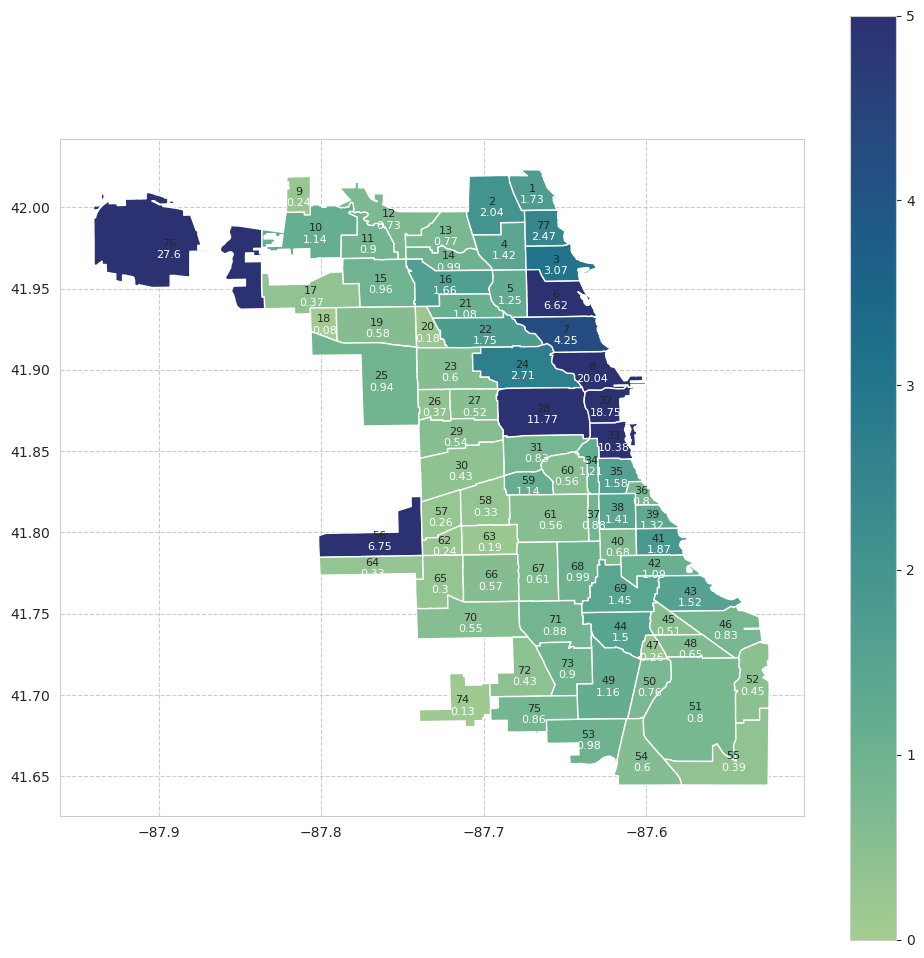

In [176]:
plot_metrics_on_map(geo_df, metrics_spark_lr, 'MAE', vmin=0, vmax=5)

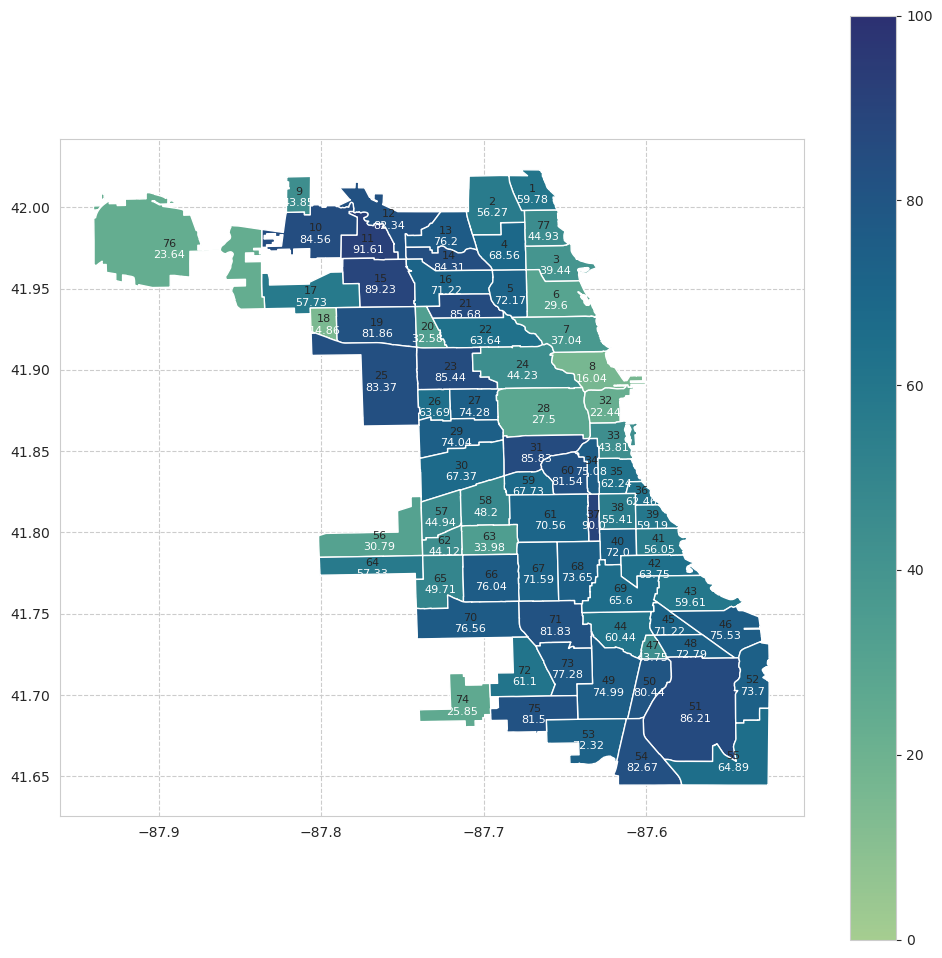

In [177]:
plot_metrics_on_map(geo_df, metrics_spark_lr, 'SMAPE', vmin=0, vmax=100)

#### Модель Spark ML XGBoost

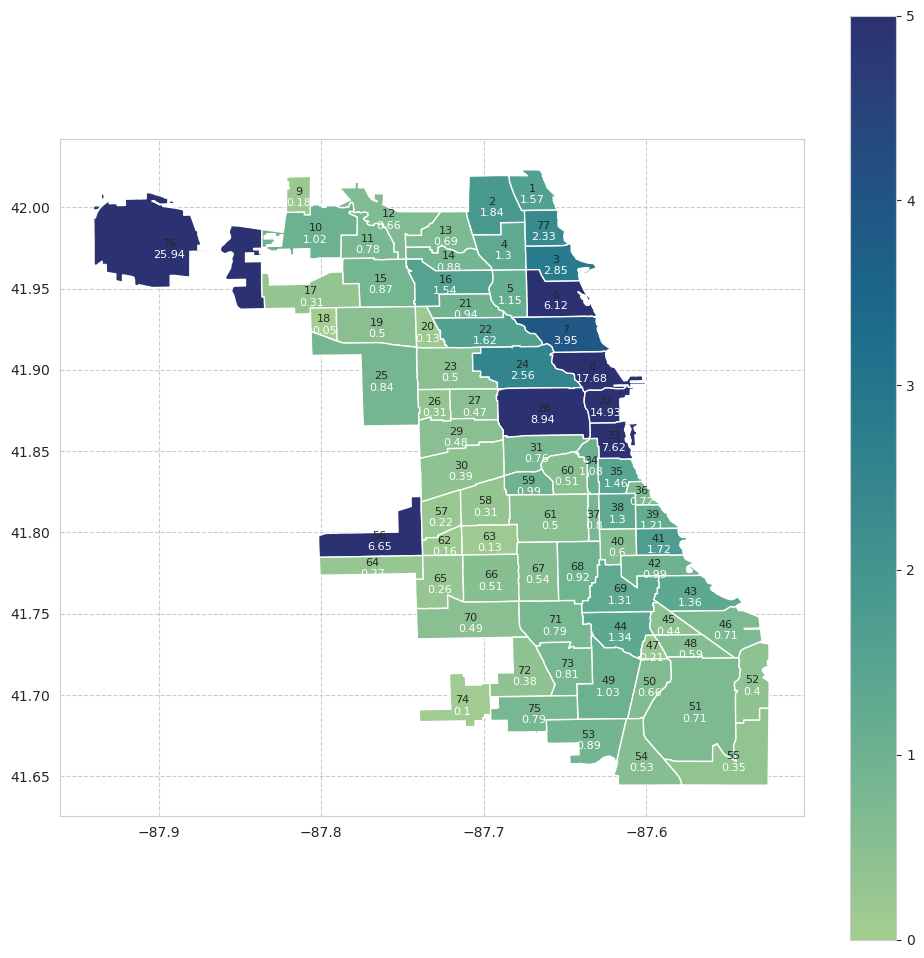

In [178]:
plot_metrics_on_map(geo_df, metrics_spark_xgb, 'MAE', vmin=0, vmax=5)

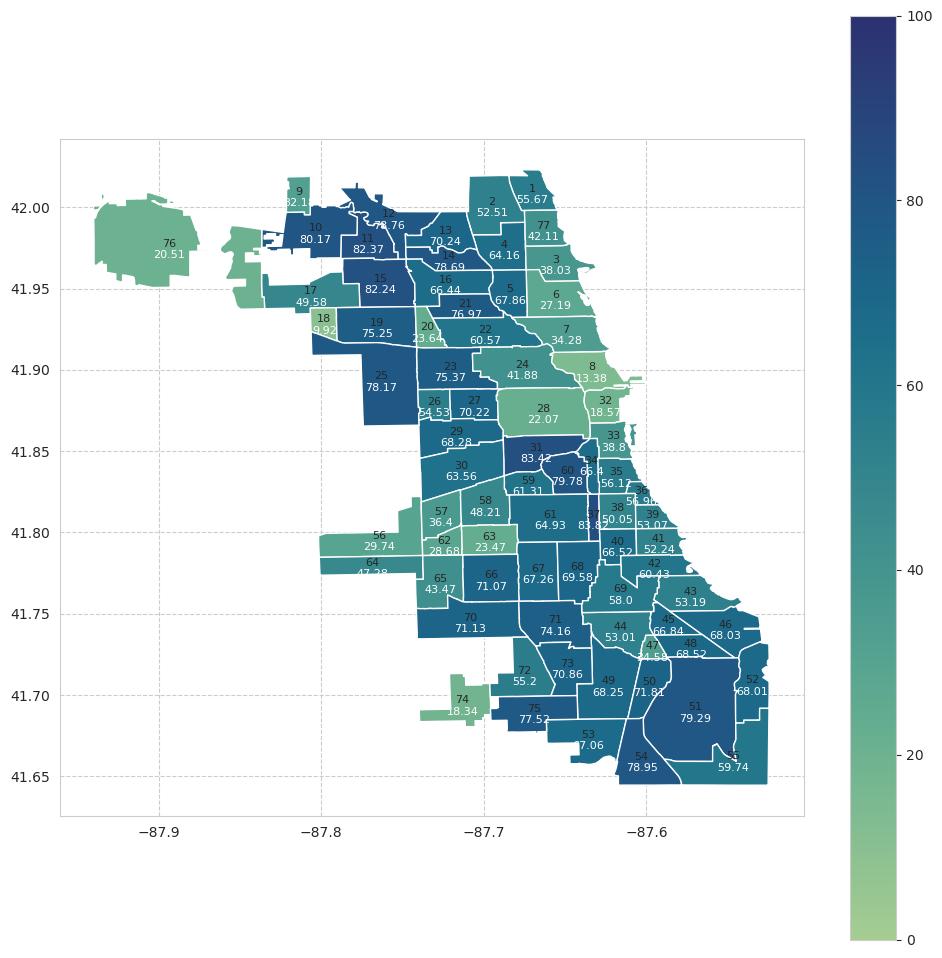

In [179]:
plot_metrics_on_map(geo_df, metrics_spark_xgb, 'SMAPE', vmin=0, vmax=100)

#### Модель ElasticNet на PandasUDF

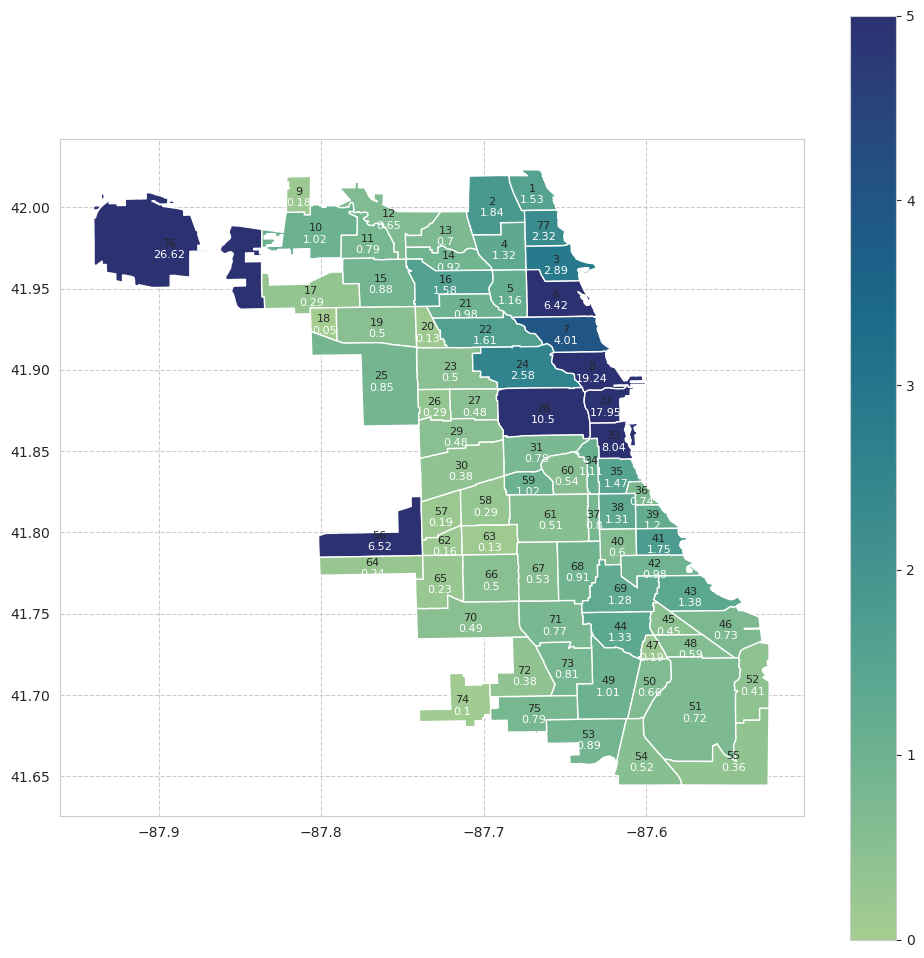

In [180]:
plot_metrics_on_map(geo_df, metrics_udf_lr, 'MAE', vmin=0, vmax=5)

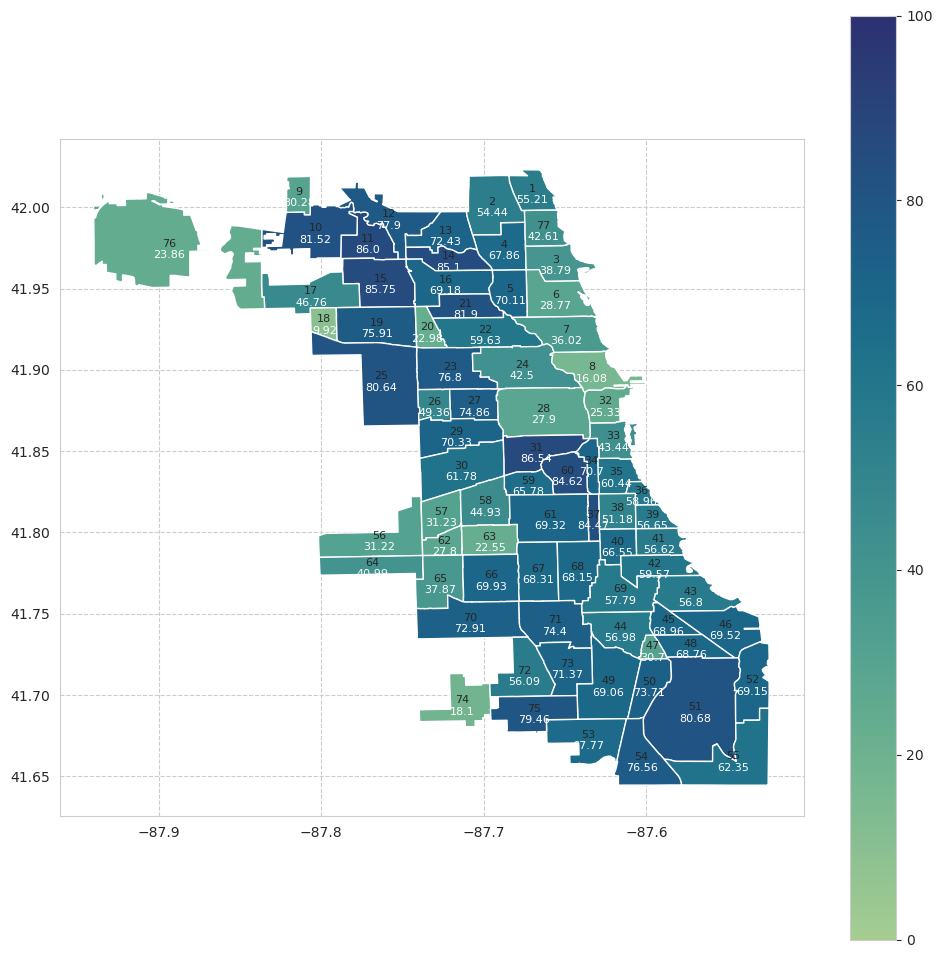

In [181]:
plot_metrics_on_map(geo_df, metrics_udf_lr, 'SMAPE', vmin=0, vmax=100)

#### Модль XGBoost на PandasUDF

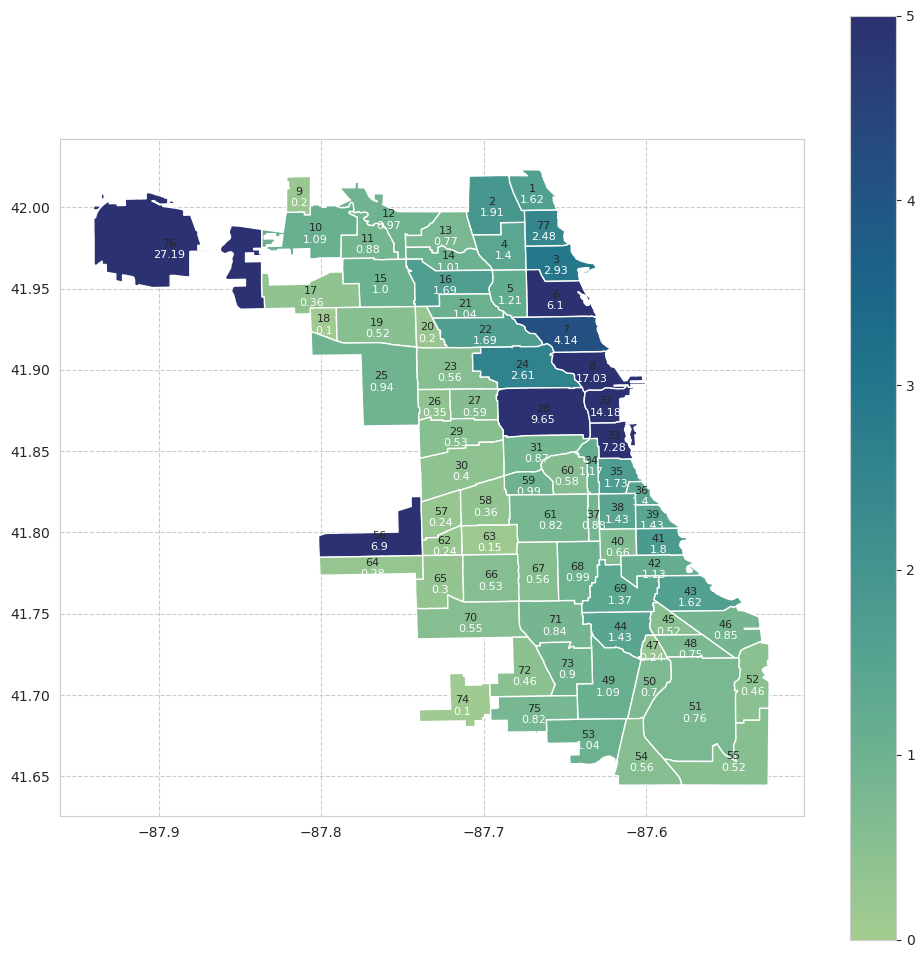

In [182]:
plot_metrics_on_map(geo_df, metrics_udf_xgb, 'MAE', vmin=0, vmax=5)

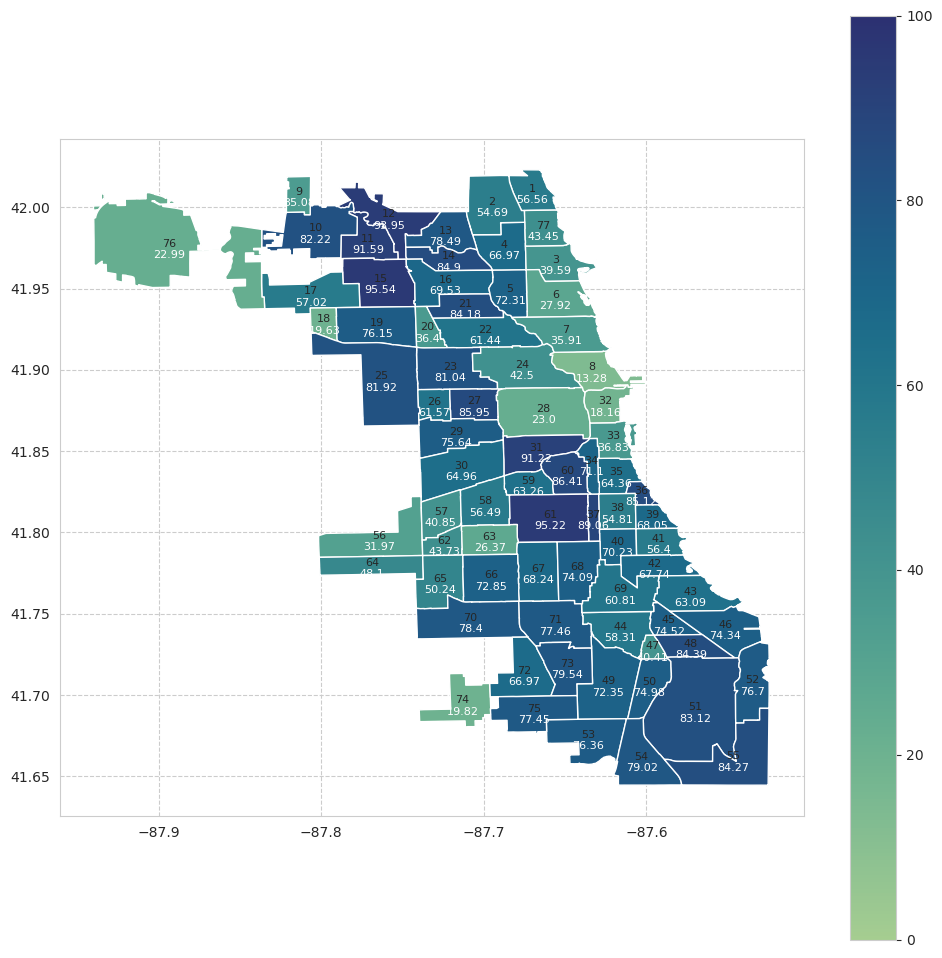

In [183]:
plot_metrics_on_map(geo_df, metrics_udf_xgb, 'SMAPE', vmin=0, vmax=100)

### Сравнение моделей по MASE (Mean Absolute Scaled Error)

#### Модель Spark ML ElasticNet

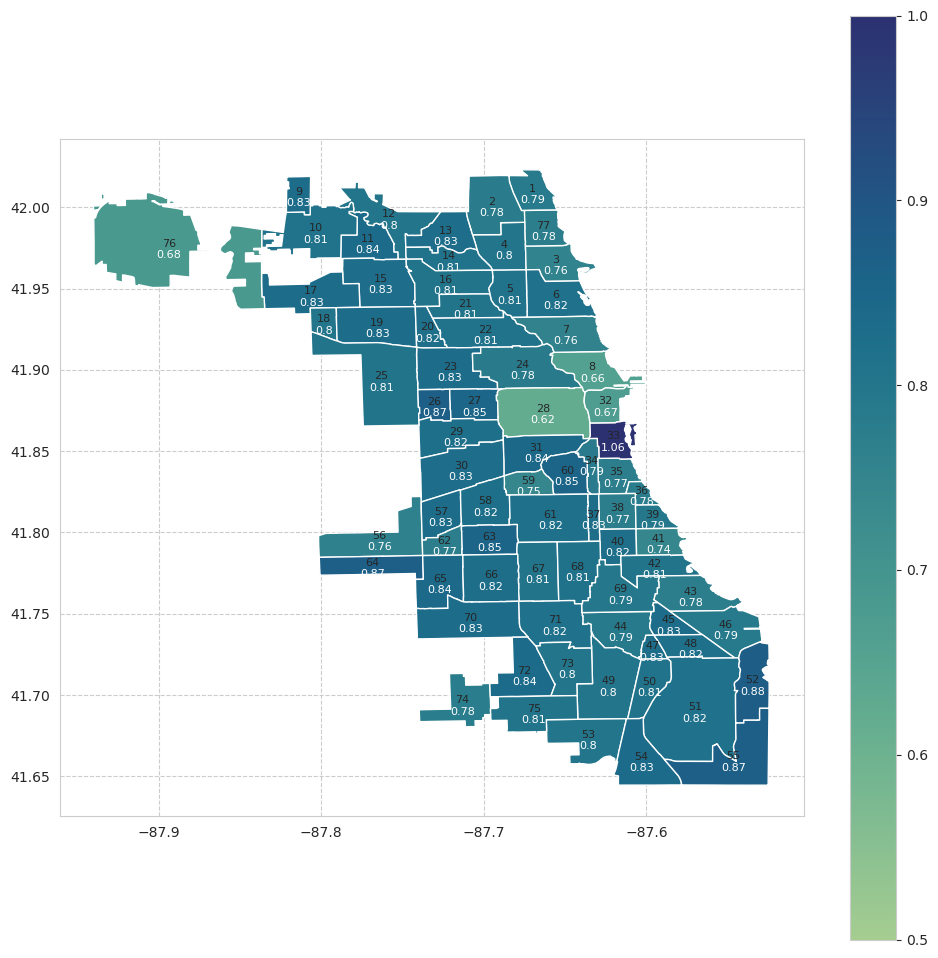

In [184]:
plot_metrics_on_map(geo_df, metrics_spark_lr, 'MASE', vmin=0.5, vmax=1)

#### Модель Spark ML XGBoost

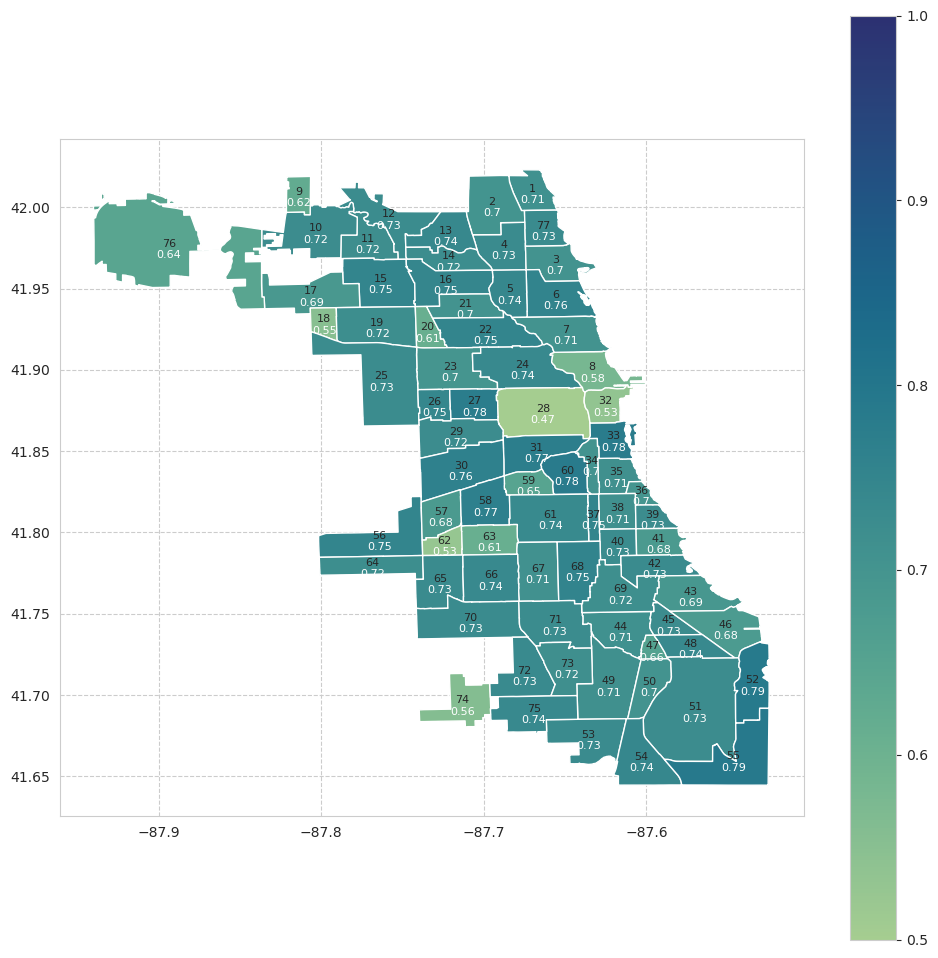

In [185]:
plot_metrics_on_map(geo_df, metrics_spark_xgb, 'MASE', vmin=0.5, vmax=1)

#### Модель ElasticNet на PandasUDF

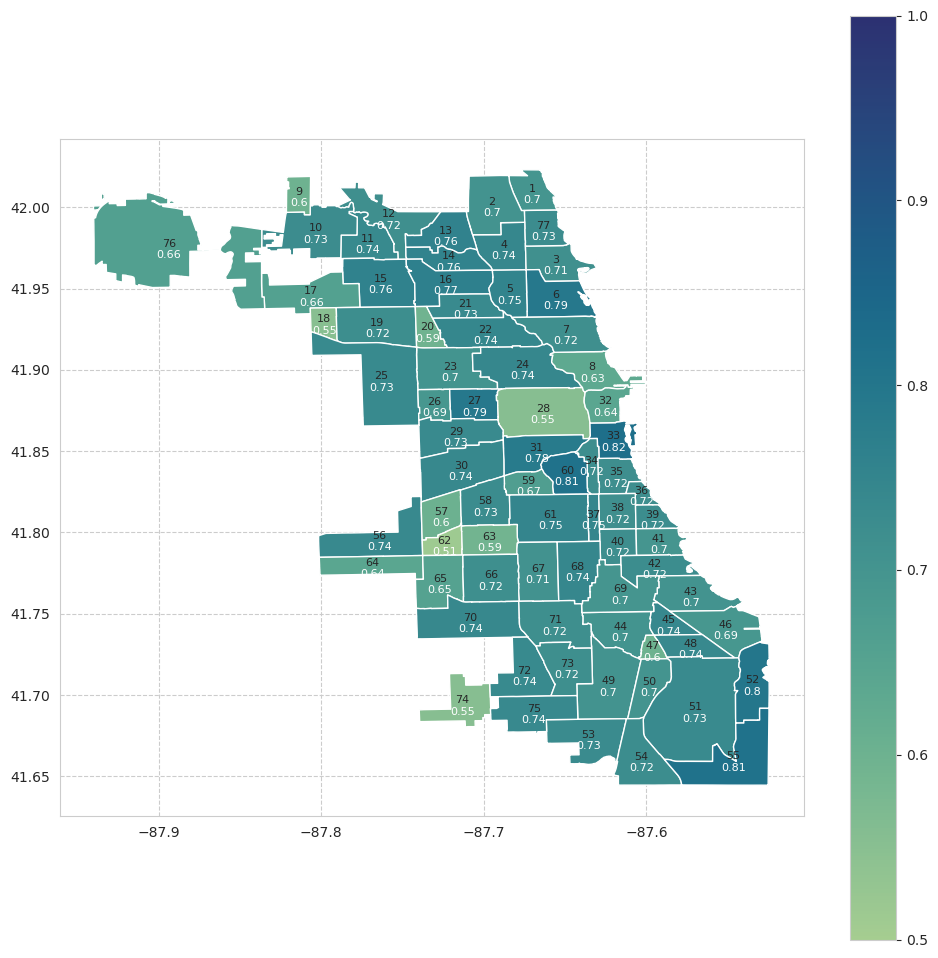

In [186]:
plot_metrics_on_map(geo_df, metrics_udf_lr, 'MASE', vmin=0.5, vmax=1)

#### Модель XGBoost на PandasUDF

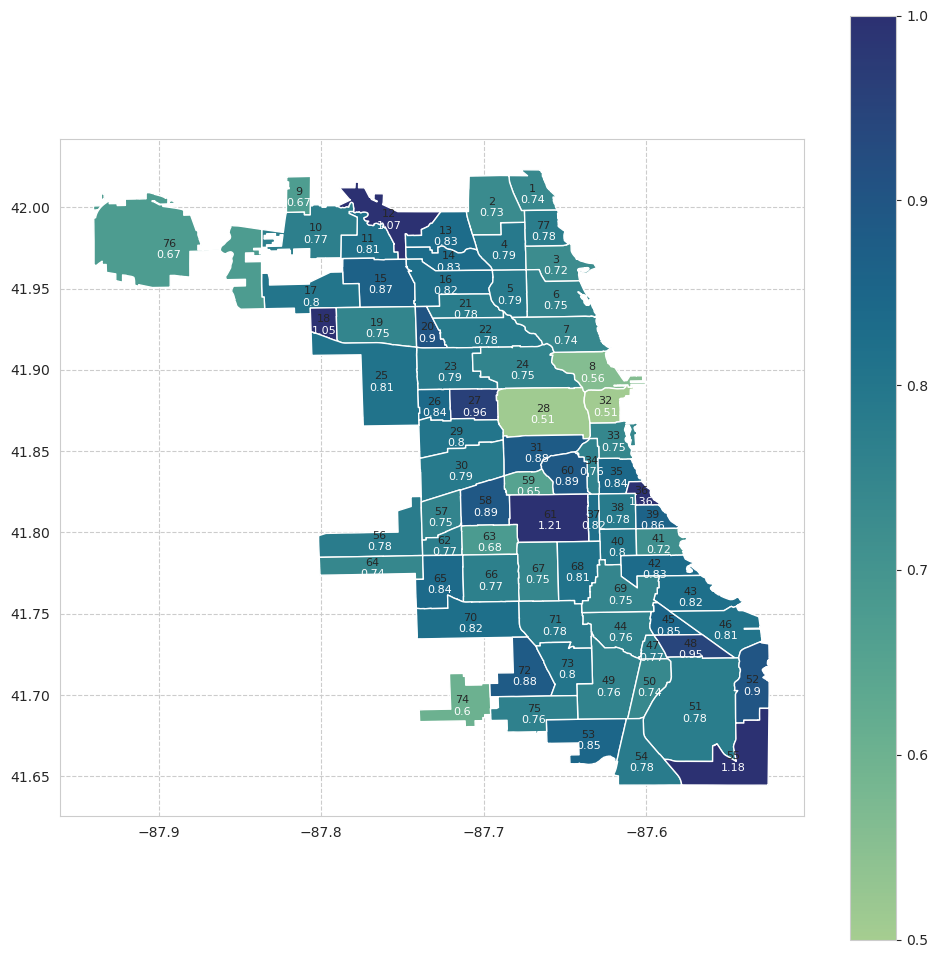

In [187]:
plot_metrics_on_map(geo_df, metrics_udf_xgb, 'MASE', vmin=0.5, vmax=1)

### Выводы

Было проведено сравнение двух подзодов предсказания:  
- Предсказание одной распределенной моделью  
- Предсказание отдельными моделями

В том и в другм случае использовались модели линейно регрессией с регуляризацией ElasticNet и градиентный бустинг XGBoost. Все предсказания моделей подвергались постобработке:  
- Отрицательные значения пердсказаний приравнивались к нулю
- Дробные значения округлялись до ближайшего целого
  
В качестве метрик изначально было предложено использовать MAE и MAPE. С MAPE с самого начала мы столкнулись с трудностями, а именно с "взрывающимися" метриками, т.к. в данных было много нулевых истиных значений целевого признака. После этого MAPE было предложено изменить на SMAPE с добавленным коэффициентом epsilon=1E-10.  
Тем не менее возникла проблема при сравнении качества предсказаний для отдельных регионов между собой. Так например для тех регионов, где было много поездок такси, метрики MAE были сравнительно большие, а SMAPE маленькие. Для регионов с небольшим количеством поездок - наоборот, MAE были маленькие, а SMAPE большие.  
Для сравнения качества предсказания моделей по регионам было предложено использовать метрику MASE (Mean Absolute Scaled Error). MASE вычисляется как MAE измеряемой модели деленная на MAE наивной модели (в данном случае предсказание по предыдущему значению). MASE будет меньше единице, если модель предсказывает лучше чем наивная модель и больше идиницы в обратном случае.

In [188]:
metrics_summary

spark_lr  spark_xgb     udf_lr    udf_xgb
MAE     2.195383   1.928181   2.026907   2.021876
SMAPE  62.516548  56.842647  58.018919  62.981630
MASE    0.806613   0.707107   0.708117   0.805751

Как видно из таблицы и графиков распределения метрик по регионам, метрика MAE, даже усредненная малоинформативна в нашем случае. В целом более адекватно показывает качество моделей и более информативна.

##### Линейная регрессия несколько моделей

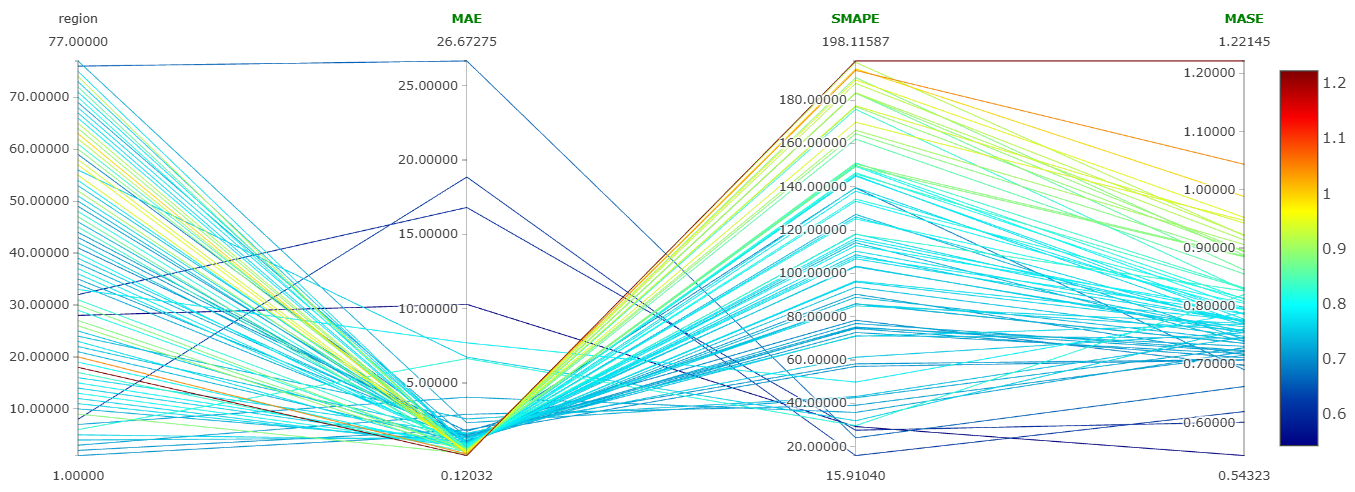

In [189]:
display.Image("charts/udf_lr_run.png")

##### XGBoost несколько моделей

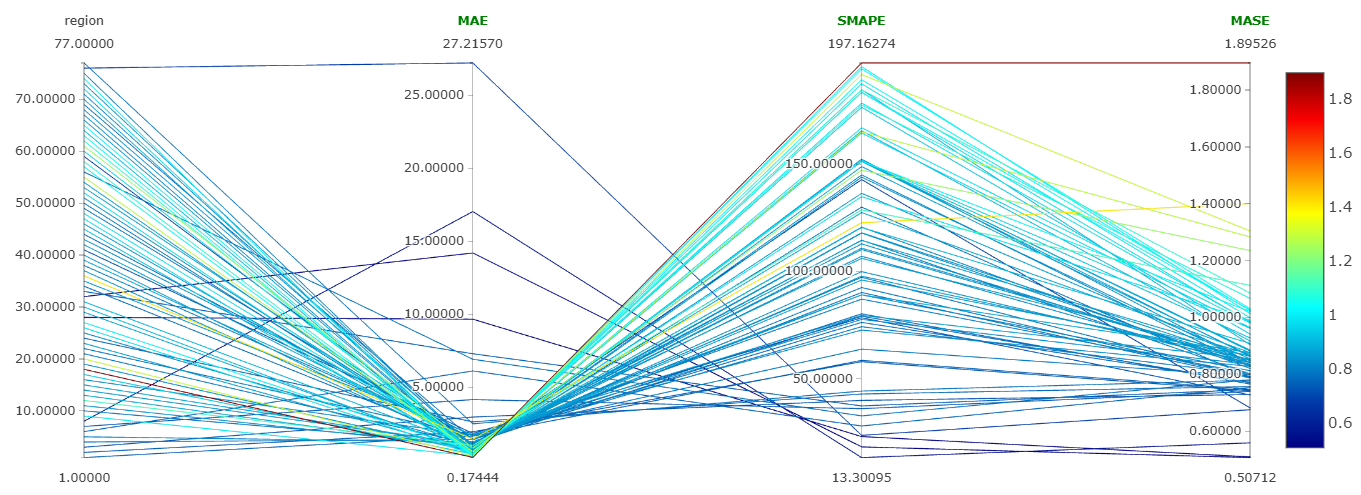

In [190]:
display.Image("charts/udf_xgb_run.png")

(графики взяты из mlflow без постобработки, поэтому значения метрик могут отличаться)

Из распределения качества метрик на карте, можно заметить, что одиночные модели в целом имеют более равномерное распределение качества предсказаний.  Интересно, что при использовании нескольких моделей линейной регрессии в среднем работает лучше чем использование одной модели линейной регрессии. Вероятно из-за нелинейных зависимостей по различным регионам.  
При этом несколько моделей градиентного бустинга предсказывают хуже чем одна. Можно предположить, что в случае нескольких моделей, не хватает данных, т.к. используются данные только одного региона, а для хорошего обучения градиентного бустинга требуется больше данных чем для линейной регрессии.

Предложения для улучшения качества предсказаний моделей
- Для улучшения предсказаний возможно следует пересмотреть географические группы по которым делаются пресказания. Так для бизнес-задачи неочевидно деление именно по регионам Community Area. Регионы могут сильно отличнаться по размерам, плотности населения, типом застройки и т.д. Возможно для улучшения прогнозов какие-либо из регионов следует объединить в один. Это тема для отдельного исследования.
- Также можно расширить пространство признаков для географических единиц. Например учитывать особенности того или иного района (состав населения, площадь и т.д.). В данном исследование эти признаки не применялись, т.к. для предсказаний отдельными моделями по регионам эти признаки будут бесполезными.
- Возможно следует провести настройку гиперпараметров для моделей градиентного бустинга.